In [2]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from tqdm import tqdm

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

In [8]:
!pip install albumentations --user

  Using cached albumentations-1.2.1-py3-none-any.whl (116 kB)
  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-win_amd64.whl (35.5 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)


In [3]:
#директории train и test датасетов
dirname_train = r'C:\Users\Slava\Desktop\ML\StartML_AMI\train'

dirname_test = r'C:\Users\Slava\Desktop\ML\StartML_AMI\test'

Тренировочный датасет довольно маленький по сравнению с тестовым, поэтому мы используем агументацию изображений (варьируем поворот и смещение, яркость и контраст, отражение по горизонтали). В тестовом датасете также присутствуют зашумленные фотографии, поэтому добавляем Гауссовский шум, его интенсивность подбиралась опытынм путем (параметр var_limit). 

In [4]:
import random
import albumentations as A

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def get_aug(image):
    angle = np.arange(-10,11,1)
    angle0 = random.choice(angle)

    shift = 0.01*np.arange(-10,11,1)
    shift0 = random.choice(shift)

    transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=[shift0,shift0], scale_limit=0, 
                        rotate_limit=[angle0,angle0], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
    A.GaussNoise(var_limit=(10,250), p=0.5)
    ])
    return transform(image=image)['image']

1. Загрузка и обработка данных

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Загрузка тренировочных данных и применение каскадов Хаара для детекции лиц на фотографиях.
Оказалось, что точность предсказаний повышается при детекции лиц на уже аугментированных и увеличенных фотографиях

In [23]:
X_train, y_train, X_train3 = [], [], []

X_train_Aug, y_train_Aug = [], []
no_face = 0
filelist = os.listdir(dirname_train)

l = ['haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 
         'haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt_tree.xml']

for fname in filelist:
    img = cv2.imread(os.path.join(dirname_train, fname), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1920, 1920), interpolation=cv2.INTER_AREA)
    X_train.append(img)
    y_train.append(int(fname.split('label')[1].split('.')[0]))

for (a,b) in zip(X_train,y_train):
    for i in range(5):
        X_train3.append(get_aug(a))
        #X_train3.append(a)
        y_train_Aug.append(b)
        #break

for img in X_train3:    
    for haar in l:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haar)
        face = face_cascade.detectMultiScale(img)
        if len(face):
          break
    for (a, b, w, h) in face:
        cv2.rectangle(img, (a, b), (a + w, b + h), (0, 0, 1920), 2)
        face = img[b:b + h, a:a + w]
    
    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)
            
        img = face[h0: h0 + size, w0: w0 + size]

    except:
        no_face+=1


    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)    
    X_train_Aug.append(img)
    

print(no_face,'faces were not found')

len(X_train_Aug), len(y_train_Aug)

217 faces were not found


(3105, 3105)

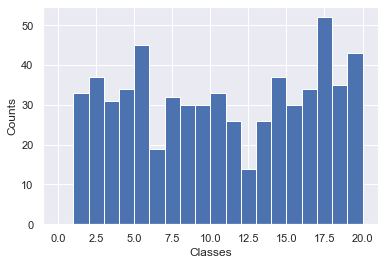

In [6]:
bins = np.arange(0, 21, 1) 

plt.hist(y_train, bins=bins, alpha=1)
plt.xlabel('Classes')
plt.ylabel('Counts')

plt.show()

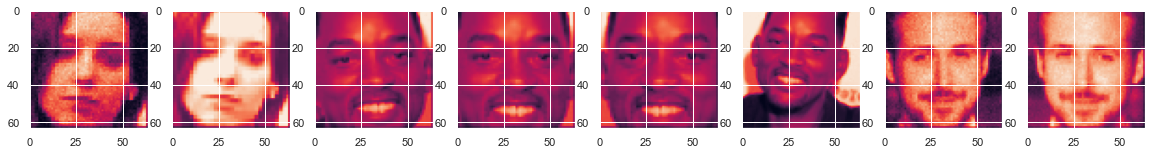

In [10]:
fig, axx = plt.subplots(1, 8, figsize=(20, 10))

for i in range(8):
    img = X_train_Aug[i+62]
    axx[i].imshow(img)

Загрузка тестовых данных. Тестовые изображения загружаются в произвольном порядке, поэтому сделаем сортировку по номерам, указанным в названиях изображений.
Тестовый датасет мы не аугментируем, но перед детекцией лиц делаем rescale до (256, 256), а обрезанные прямоугольники с лицами снова уменьшаем до (64, 64) 

In [12]:
def sort_by_index(fname):
    return int(fname.split('.')[0].split('img')[1])

In [24]:
X_test = []
Names = []
no_face = 0

for fname in tqdm(sorted(os.listdir(dirname_test), key=sort_by_index)):
    img = cv2.imread(os.path.join(dirname_test, fname), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1920, 1920), interpolation=cv2.INTER_AREA) 
    Names.append(fname)
    l = ['haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 
         'haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt_tree.xml']
    
    for haar in l:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haar)
        face = face_cascade.detectMultiScale(img)
        if len(face):
          break
    for (a, b, w, h) in face:
        cv2.rectangle(img, (a, b), (a + w, b + h), (0, 0, 1920), 2)
        face = img[b:b + h, a:a + w]
    
    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)
            
        img = face[h0: h0 + size, w0: w0 + size]

    except:
        no_face+=1

    
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    X_test.append(img)
    
print(no_face,'faces were not found')
len(X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 4150/4150 [18:36<00:00,  3.72it/s]

281 faces were not found


4150

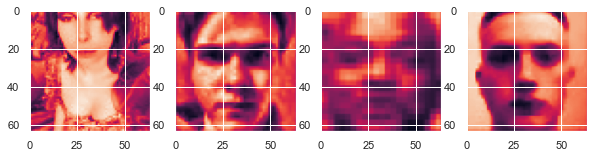

In [14]:
fig, axx = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    img = X_test[i+90]
    axx[i].imshow(img)

Признаки для классификации извлекаем с помощью метода HOG. Изменение параметров преобразования на практике не дало прироста в точности.

In [25]:
hog_img_train = []
for i in range(len(X_train_Aug)):
    fd, hog_image = hog(X_train_Aug[i], orientations=8, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    hog_img_train.append(hog_image)

In [26]:
hog_img_test = []
for i in range(len(X_test)):
    fd, hog_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    hog_img_test.append(hog_image)

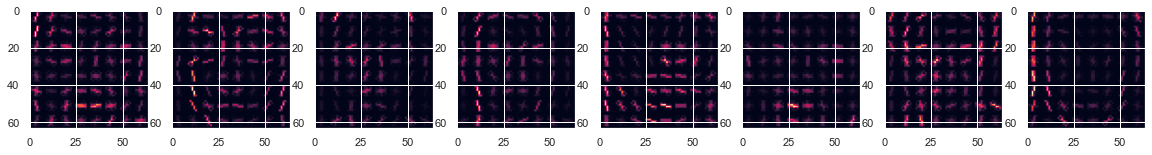

In [17]:
fig, axx = plt.subplots(1, 8, figsize=(20, 10))

for i in range(8):
    img = hog_img_test[i+45]
    axx[i].imshow(img)

2. Обучение модели и подбор гиперпараметров

In [27]:
X_train_flatten = np.array([el.ravel() for el in hog_img_train])
X_test_flatten = np.array([el.ravel() for el in hog_img_test])

Точность модели буду оценивать на отложенной валидационной выборке

In [28]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_flatten, y_train_Aug, stratify=y_train_Aug, random_state=42)

Для уменьшения размерности пространства признаков мы используем метод главных компонент. Число компонент можно примерно оценить по правилу Кайзера, чтобы при данном числе компонент доля объясненной дисперсии составляла 95%. Перед PCA данные необходимо отнормировать. Я пробовала MinMaxScaler и StandardScaler, последний показал себя чуть лучше.
Также для уменьшения размерности я пробовала LinearDiscriminantAnalysis, но прироста в точности этот метод не дал  

Text(0, 0.5, 'cumulative explained variance')

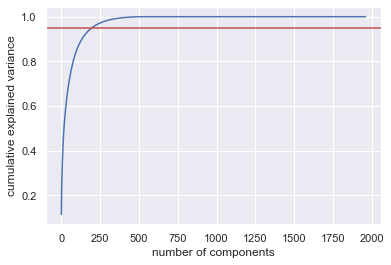

In [26]:
pca = PCA().fit(X_tr, y_tr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
scl = StandardScaler()
pca = KernelPCA()
model_svm = SVC(probability=True)

pipe = Pipeline(steps=[('scl', scl), ('pca', pca), ('svm', model_svm)])

param_grid = {
    "pca__n_components": [148],
    "pca__kernel": ['rbf'],
    'svm__C': [21],
    'svm__kernel': ['rbf'],
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                           scoring = 'accuracy', cv = 10, 
                           n_jobs = -1, verbose = 2)

grid.fit(X_tr, y_tr)

print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")
print(f"val-set score: {grid.score(X_val, y_val):.3f}")

In [25]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(task_type='GPU', eval_metric='AUC',
                         early_stopping_rounds=25, verbose=100)

parameters = {
                 #'learning_rate' : [i / 100 for i in range(10, 24)],
                  'depth': [3, 4],
                  'l2_leaf_reg': [7, 9, 11, 13],
                  'border_count' : [i for i in range(192, 256, 16)], 
                  'iterations' : [i for i in range(1000, 4001, 200)], 
                 }

grid_cbc = cbc.grid_search(parameters, X_tr, y_tr, plot=True)
#grid_cbc.fit(X_tr, y_tr)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 37.4ms	remaining: 37.3s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 4.7s	remaining: 41.8s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 9.74s	remaining: 38.7s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 14.5s	remaining: 33.6s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 20s	remaining: 29.9s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 24.5s	remaining: 24.4s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 29.7s	remaining: 19.7s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9952721	best: 0.9952721 (0)	total: 33.6s	remaining: 4h 46m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 44ms	remaining: 43.9s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.69s	remaining: 50.6s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 11s	remaining: 43.8s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.9s	remaining: 36.9s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.6s	remaining: 32.2s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.9s	remaining: 26.8s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 32.2s	remaining: 21.4s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37s	remaining: 15.8s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.7s	remaining: 10.6s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.5s	remaining: 5.22s
999:	test: 0.9958401	best: 0.9958518 (991)	total: 52.5s	remaining: 0us
bestTest = 0.9958518397
bestIteration = 991
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9958518	best: 0.995

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 75.7ms	remaining: 1m 15s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.38s	remaining: 47.9s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.4s	remaining: 41.4s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.3s	remaining: 35.6s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 20.8s	remaining: 31.1s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 25.9s	remaining: 25.8s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.3s	remaining: 20.8s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.1s	remaining: 15.4s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.3s	remaining: 10.3s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9950902	best: 0.9958518 (1)	total: 2m 10s	remaining: 6h 8m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.5ms	remaining: 40.5s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 6.56s	remaining: 58.4s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 12.1s	remaining: 47.9s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 17.5s	remaining: 40.6s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 22.8s	remaining: 34s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 27.9s	remaining: 27.7s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9934598	best: 0.9958518 (1)	total: 2m 42s	remaining: 5h 44m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 63.8ms	remaining: 1m 16s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 4.82s	remaining: 52.4s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.5s	remaining: 52.3s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.7s	remaining: 46.8s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 20.7s	remaining: 41.3s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 25.6s	remaining: 35.8s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 30.9s	remaining: 30.8s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.9952721	best: 0.9958518 (1)	total: 3m 17s	remaining: 5h 34m


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 76.5ms	remaining: 1m 31s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.03s	remaining: 54.7s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.8s	remaining: 53.5s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.2s	remaining: 48.5s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 22s	remaining: 43.8s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 27.1s	remaining: 37.9s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.9s	remaining: 31.8s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37s	remaining: 26.4s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.7s	remaining: 20.8s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.7s	remaining: 15.5s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51.4s	remaining: 10.2s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 56.9s	remaining: 5.12s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric on trai

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 63.6ms	remaining: 1m 16s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.76s	remaining: 1m 2s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.9s	remaining: 54.1s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.7s	remaining: 47s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 20.9s	remaining: 41.7s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.6s	remaining: 37.1s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.9s	remaining: 31.8s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.8s	remaining: 26.2s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.3s	remaining: 21.1s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
6:	loss: 0.9950902	best: 0.9961328 (5)	total: 5m 1s	remaining: 6h 2m 57s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 37.5ms	remaining: 44.9s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.28s	remaining: 57.5s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.4s	remaining: 51.6s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.9s	remaining: 47.6s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.1s	remaining: 42s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.2s	remaining: 36.6s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
7:	loss: 0.9934598	best: 0.9961328 (5)	total: 5m 32s	remaining: 5h 49m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 74.6ms	remaining: 1m 44s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 4.99s	remaining: 1m 4s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11s	remaining: 1m 5s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.8s	remaining: 57.6s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.3s	remaining: 52.9s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26.5s	remaining: 47.5s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 31.3s	remaining: 41.6s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
8:	loss: 0.9952721	best: 0.9961328 (5)	total: 6m 8s	remaining: 5h 42m 47s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 39.9ms	remaining: 55.8s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.28s	remaining: 1m 7s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.4s	remaining: 1m 1s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.4s	remaining: 56.2s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.8s	remaining: 51.9s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26s	remaining: 46.6s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.3s	remaining: 41.6s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.4s	remaining: 36.3s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.5s	remaining: 31.1s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.4s	remaining: 25.7s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51.4s	remaining: 20.5s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 56.4s	remaining: 15.3s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric on tra

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 63.3ms	remaining: 1m 28s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.55s	remaining: 1m 11s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.9s	remaining: 1m 4s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16.7s	remaining: 1m
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.7s	remaining: 54.1s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 27.1s	remaining: 48.7s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 32.2s	remaining: 42.8s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 37.7s	remaining: 37.6s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.6s	remaining: 31.8s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
10:	loss: 0.9950902	best: 0.9961328 (5)	total: 7m 52s	remaining: 5h 58m 27s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.3ms	remaining: 56.3s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.71s	remaining: 1m 13s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.6s	remaining: 1m 3s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 16.3s	remaining: 59.5s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.2s	remaining: 52.7s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.5s	remaining: 47.6s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
11:	loss: 0.9934598	best: 0.9961328 (5)	total: 8m 23s	remaining: 5h 49m 56s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 69.4ms	remaining: 1m 50s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.33s	remaining: 1m 19s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11.2s	remaining: 1m 17s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.1s	remaining: 1m 9s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.4s	remaining: 1m 3s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26.8s	remaining: 58.8s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.2s	remaining: 53.5s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
12:	loss: 0.9952721	best: 0.9961328 (5)	total: 9m	remaining: 5h 45m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 39.4ms	remaining: 1m 2s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.32s	remaining: 1m 18s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.5s	remaining: 1m 12s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.7s	remaining: 1m 7s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.3s	remaining: 1m 3s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.2s	remaining: 57.5s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.5s	remaining: 52.4s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.1s	remaining: 46.3s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.5s	remaining: 41.4s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.4s	remaining: 36.8s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 53s	remaining: 31.7s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 58.2s	remaining: 26.4s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric on t

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 38.3ms	remaining: 1m 1s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.3s	remaining: 1m 18s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 11.1s	remaining: 1m 17s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16.2s	remaining: 1m 10s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.6s	remaining: 1m 4s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.7s	remaining: 58.5s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.7s	remaining: 52.6s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 37.1s	remaining: 47.6s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.1s	remaining: 42s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
14:	loss: 0.9950902	best: 0.9961328 (5)	total: 10m 46s	remaining: 5h 56m 55s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 74.8ms	remaining: 1m 59s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.22s	remaining: 1m 17s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.7s	remaining: 1m 14s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.9s	remaining: 1m 8s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.4s	remaining: 1m 3s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.7s	remaining: 58.5s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
15:	loss: 0.9934598	best: 0.9961328 (5)	total: 11m 18s	remaining: 5h 50m 33s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 41ms	remaining: 1m 13s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.39s	remaining: 1m 30s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11s	remaining: 1m 27s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.5s	remaining: 1m 21s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.6s	remaining: 1m 15s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.2s	remaining: 1m 10s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.1s	remaining: 1m 4s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 0.9952721	best: 0.9961328 (5)	total: 11m 55s	remaining: 5h 47m 2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 41.2ms	remaining: 1m 14s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.33s	remaining: 1m 29s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.2s	remaining: 1m 21s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15s	remaining: 1m 14s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.3s	remaining: 1m 10s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.3s	remaining: 1m 8s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.2s	remaining: 1m 2s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.3s	remaining: 56.8s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.4s	remaining: 51.6s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.3s	remaining: 46.2s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51.2s	remaining: 40.9s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 56.7s	remaining: 36s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric on 

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 74.2ms	remaining: 2m 13s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.36s	remaining: 1m 30s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.7s	remaining: 1m 25s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.8s	remaining: 1m 18s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 20.7s	remaining: 1m 12s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 25.8s	remaining: 1m 6s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.2s	remaining: 1m 2s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.2s	remaining: 56.8s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.4s	remaining: 51.7s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
18:	loss: 0.9950902	best: 0.9961328 (5)	total: 13m 38s	remaining: 5h 54m


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.1ms	remaining: 1m 12s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.12s	remaining: 1m 26s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 9.99s	remaining: 1m 19s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.5s	remaining: 1m 17s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 20.2s	remaining: 1m 10s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 25.6s	remaining: 1m 6s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
19:	loss: 0.9934598	best: 0.9961328 (5)	total: 14m 9s	remaining: 5h 48m 10s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 63.3ms	remaining: 2m 6s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.31s	remaining: 1m 39s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.9s	remaining: 1m 37s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.2s	remaining: 1m 31s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 22s	remaining: 1m 27s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27s	remaining: 1m 20s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.4s	remaining: 1m 15s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
20:	loss: 0.9952721	best: 0.9961328 (5)	total: 14m 45s	remaining: 5h 45m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 68.9ms	remaining: 2m 17s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 4.9s	remaining: 1m 32s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 9.97s	remaining: 1m 29s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.7s	remaining: 1m 28s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.3s	remaining: 1m 20s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 25.8s	remaining: 1m 17s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.1s	remaining: 1m 12s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.2s	remaining: 1m 7s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.1s	remaining: 1m 1s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.4s	remaining: 56.6s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 52.4s	remaining: 52.3s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.6s	remaining: 47s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric 

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 40ms	remaining: 1m 20s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.26s	remaining: 1m 38s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.5s	remaining: 1m 33s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.8s	remaining: 1m 29s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.2s	remaining: 1m 24s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.6s	remaining: 1m 19s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31s	remaining: 1m 12s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.6s	remaining: 1m 7s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.1s	remaining: 1m 1s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
22:	loss: 0.9950902	best: 0.9961328 (5)	total: 16m 29s	remaining: 5h 50m 41s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 216ms	remaining: 7m 12s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 4.79s	remaining: 1m 30s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.7s	remaining: 1m 35s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.8s	remaining: 1m 29s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.1s	remaining: 1m 24s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.4s	remaining: 1m 18s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
23:	loss: 0.9934598	best: 0.9961328 (5)	total: 17m 1s	remaining: 5h 46m 8s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 172ms	remaining: 6m 19s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.81s	remaining: 2m
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.7s	remaining: 1m 46s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.6s	remaining: 1m 44s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.3s	remaining: 1m 35s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26.6s	remaining: 1m 30s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32s	remaining: 1m 25s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.9952721	best: 0.9961328 (5)	total: 17m 37s	remaining: 5h 43m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 38.2ms	remaining: 1m 24s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.43s	remaining: 1m 52s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.5s	remaining: 1m 44s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.1s	remaining: 1m 41s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.2s	remaining: 1m 35s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.4s	remaining: 1m 29s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 32s	remaining: 1m 25s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37.2s	remaining: 1m 19s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.5s	remaining: 1m 14s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.6s	remaining: 1m 8s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 53s	remaining: 1m 3s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 58s	remaining: 57.9s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric o

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 38.3ms	remaining: 1m 24s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.56s	remaining: 1m 55s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.4s	remaining: 1m 43s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.6s	remaining: 1m 38s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21s	remaining: 1m 34s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.1s	remaining: 1m 28s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 30.7s	remaining: 1m 21s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.5s	remaining: 1m 17s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.3s	remaining: 1m 12s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
26:	loss: 0.9950902	best: 0.9961328 (5)	total: 19m 21s	remaining: 5h 47m 50s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 45.8ms	remaining: 1m 40s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.75s	remaining: 1m 59s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.6s	remaining: 1m 45s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.9s	remaining: 1m 40s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 22s	remaining: 1m 38s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.8s	remaining: 1m 30s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
27:	loss: 0.9934598	best: 0.9961328 (5)	total: 19m 54s	remaining: 5h 44m 10s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 39.7ms	remaining: 1m 35s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.47s	remaining: 2m 4s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.7s	remaining: 1m 57s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.4s	remaining: 1m 54s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 22.1s	remaining: 1m 50s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.2s	remaining: 1m 43s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.3s	remaining: 1m 36s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
28:	loss: 0.9952721	best: 0.9961328 (5)	total: 20m 31s	remaining: 5h 41m 47s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 66.2ms	remaining: 2m 38s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.3s	remaining: 2m
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.4s	remaining: 1m 53s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.4s	remaining: 1m 47s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.4s	remaining: 1m 41s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.3s	remaining: 1m 39s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.2s	remaining: 1m 33s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.9s	remaining: 1m 29s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.7s	remaining: 1m 23s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.5s	remaining: 1m 17s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51.7s	remaining: 1m 12s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.2s	remaining: 1m 7s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metri

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 41.6ms	remaining: 1m 39s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.28s	remaining: 2m
200:	test: 0.9870272	best: 0.9870272 (200)	total: 11.1s	remaining: 2m 1s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16.2s	remaining: 1m 52s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.3s	remaining: 1m 46s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 27s	remaining: 1m 42s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.9s	remaining: 1m 35s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 37s	remaining: 1m 29s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.3s	remaining: 1m 24s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
30:	loss: 0.9950902	best: 0.9961328 (5)	total: 22m 16s	remaining: 5h 45m 33s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.9ms	remaining: 1m 38s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.98s	remaining: 2m 16s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 11s	remaining: 2m
300:	test: 0.9895000	best: 0.9895084 (298)	total: 16.5s	remaining: 1m 55s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 22.2s	remaining: 1m 50s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 27.6s	remaining: 1m 44s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
31:	loss: 0.9934598	best: 0.9961328 (5)	total: 22m 48s	remaining: 5h 42m 10s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 40.7ms	remaining: 1m 45s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.83s	remaining: 2m 24s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11.4s	remaining: 2m 16s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.4s	remaining: 2m 5s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 22s	remaining: 2m
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.4s	remaining: 1m 54s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.7s	remaining: 1m 48s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
32:	loss: 0.9952721	best: 0.9961328 (5)	total: 23m 25s	remaining: 5h 39m 59s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 38.3ms	remaining: 1m 39s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.37s	remaining: 2m 12s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.6s	remaining: 2m 6s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.2s	remaining: 2m 3s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.8s	remaining: 1m 59s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.5s	remaining: 1m 51s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.6s	remaining: 1m 45s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37s	remaining: 1m 40s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.1s	remaining: 1m 34s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.2s	remaining: 1m 29s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 52.4s	remaining: 1m 23s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.4s	remaining: 1m 18s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this met

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 81.6ms	remaining: 3m 32s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.46s	remaining: 2m 15s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.6s	remaining: 2m 7s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16.3s	remaining: 2m 4s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.5s	remaining: 1m 58s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.7s	remaining: 1m 51s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 32.3s	remaining: 1m 47s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 38s	remaining: 1m 42s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.4s	remaining: 1m 35s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.9950902	best: 0.9961328 (5)	total: 25m 10s	remaining: 5h 43m 11s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 41.2ms	remaining: 1m 47s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.56s	remaining: 2m 17s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.2s	remaining: 2m 1s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.6s	remaining: 1m 59s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 20.6s	remaining: 1m 53s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.4s	remaining: 1m 50s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.9934598	best: 0.9961328 (5)	total: 25m 42s	remaining: 5h 39m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 73.9ms	remaining: 3m 26s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.47s	remaining: 2m 26s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11.3s	remaining: 2m 25s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.3s	remaining: 2m 15s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.4s	remaining: 2m 8s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.5s	remaining: 2m 6s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.5s	remaining: 1m 59s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
36:	loss: 0.9952721	best: 0.9961328 (5)	total: 26m 19s	remaining: 5h 37m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 75.6ms	remaining: 3m 31s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5s	remaining: 2m 13s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.2s	remaining: 2m 12s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.5s	remaining: 2m 9s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.4s	remaining: 2m 7s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.8s	remaining: 2m 2s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.9s	remaining: 1m 56s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.8s	remaining: 1m 50s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.8s	remaining: 1m 44s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.6s	remaining: 1m 40s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 52.6s	remaining: 1m 34s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.6s	remaining: 1m 28s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metri

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 63.6ms	remaining: 2m 58s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.03s	remaining: 2m 14s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.4s	remaining: 2m 13s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.6s	remaining: 2m 9s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21s	remaining: 2m 5s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.1s	remaining: 1m 59s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 30.9s	remaining: 1m 53s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.2s	remaining: 1m 48s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.3s	remaining: 1m 43s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
38:	loss: 0.9950902	best: 0.9961328 (5)	total: 28m 3s	remaining: 5h 40m 16s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 64.6ms	remaining: 3m
100:	test: 0.9748183	best: 0.9748183 (100)	total: 4.92s	remaining: 2m 11s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.6s	remaining: 2m 17s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.3s	remaining: 2m 6s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 20.5s	remaining: 2m 2s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 25.6s	remaining: 1m 57s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
39:	loss: 0.9934598	best: 0.9961328 (5)	total: 28m 34s	remaining: 5h 37m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 40.4ms	remaining: 2m 1s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.27s	remaining: 2m 31s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11s	remaining: 2m 32s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.9s	remaining: 2m 22s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.3s	remaining: 2m 17s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26.6s	remaining: 2m 12s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 31.3s	remaining: 2m 4s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
40:	loss: 0.9952721	best: 0.9961328 (5)	total: 29m 10s	remaining: 5h 35m 5s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 75.6ms	remaining: 3m 46s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 4.8s	remaining: 2m 17s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.3s	remaining: 2m 22s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.6s	remaining: 2m 19s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.9s	remaining: 2m 15s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 25.9s	remaining: 2m 9s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.5s	remaining: 2m 5s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 36.4s	remaining: 1m 59s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.1s	remaining: 1m 55s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 46.7s	remaining: 1m 48s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51.7s	remaining: 1m 43s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.2s	remaining: 1m 38s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this me

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 41.7ms	remaining: 2m 5s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.25s	remaining: 2m 30s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.8s	remaining: 2m 30s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16.2s	remaining: 2m 24s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.1s	remaining: 2m 16s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.7s	remaining: 2m 12s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.3s	remaining: 2m 4s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.9s	remaining: 2m
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.8s	remaining: 1m 54s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
42:	loss: 0.9950902	best: 0.9961328 (5)	total: 30m 54s	remaining: 5h 37m 4s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 73.1ms	remaining: 3m 39s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.16s	remaining: 2m 28s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.4s	remaining: 2m 24s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.4s	remaining: 2m 18s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 20.2s	remaining: 2m 10s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 25.6s	remaining: 2m 7s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
43:	loss: 0.9934598	best: 0.9961328 (5)	total: 31m 24s	remaining: 5h 34m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 39.2ms	remaining: 2m 5s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.51s	remaining: 2m 48s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.5s	remaining: 2m 36s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.9s	remaining: 2m 33s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 20.8s	remaining: 2m 25s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26.5s	remaining: 2m 22s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 31.5s	remaining: 2m 16s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
44:	loss: 0.9952721	best: 0.9961328 (5)	total: 32m	remaining: 5h 32m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 41.8ms	remaining: 2m 13s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.57s	remaining: 2m 51s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.8s	remaining: 2m 40s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.1s	remaining: 2m 34s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.8s	remaining: 2m 32s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.5s	remaining: 2m 22s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 32s	remaining: 2m 18s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37.3s	remaining: 2m 12s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 41.7s	remaining: 2m 5s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.2s	remaining: 2m
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 52.6s	remaining: 1m 55s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.3s	remaining: 1m 49s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 46.9ms	remaining: 2m 30s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.04s	remaining: 2m 34s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.7s	remaining: 2m 38s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.6s	remaining: 2m 29s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.7s	remaining: 2m 31s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.8s	remaining: 2m 24s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 32.3s	remaining: 2m 19s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 37.8s	remaining: 2m 14s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42.7s	remaining: 2m 7s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
46:	loss: 0.9950902	best: 0.9961328 (5)	total: 33m 45s	remaining: 5h 34m 1s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 38.2ms	remaining: 2m 2s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.72s	remaining: 2m 55s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 11s	remaining: 2m 43s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 16.5s	remaining: 2m 39s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.4s	remaining: 2m 29s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.9s	remaining: 2m 24s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
47:	loss: 0.9934598	best: 0.9961328 (5)	total: 34m 17s	remaining: 5h 31m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 76.4ms	remaining: 4m 19s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.83s	remaining: 3m 10s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.8s	remaining: 2m 51s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 16.5s	remaining: 2m 49s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 21.2s	remaining: 2m 38s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.2s	remaining: 2m 37s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 32.1s	remaining: 2m 29s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
48:	loss: 0.9952721	best: 0.9961328 (5)	total: 34m 54s	remaining: 5h 29m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 36.2ms	remaining: 2m 2s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.57s	remaining: 3m 2s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.9s	remaining: 2m 53s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.3s	remaining: 2m 47s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.9s	remaining: 2m 43s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 27.4s	remaining: 2m 38s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 32.2s	remaining: 2m 29s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37.2s	remaining: 2m 23s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.1s	remaining: 2m 16s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.7s	remaining: 2m 12s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 53s	remaining: 2m 6s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.8s	remaining: 2m
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric o

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 41ms	remaining: 2m 19s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.25s	remaining: 2m 51s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.4s	remaining: 2m 46s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.9s	remaining: 2m 43s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.2s	remaining: 2m 38s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.5s	remaining: 2m 33s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.3s	remaining: 2m 25s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.4s	remaining: 2m 20s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.8s	remaining: 2m 15s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
50:	loss: 0.9950902	best: 0.9961328 (5)	total: 36m 38s	remaining: 5h 31m 16s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 257ms	remaining: 14m 34s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.42s	remaining: 2m 56s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.6s	remaining: 2m 48s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.7s	remaining: 2m 41s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.2s	remaining: 2m 38s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.6s	remaining: 2m 33s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
51:	loss: 0.9934598	best: 0.9961328 (5)	total: 37m 10s	remaining: 5h 28m 53s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 40.5ms	remaining: 2m 25s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.01s	remaining: 2m 53s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.3s	remaining: 2m 54s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.8s	remaining: 2m 53s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 20.9s	remaining: 2m 46s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 25.8s	remaining: 2m 39s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 31.4s	remaining: 2m 36s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
52:	loss: 0.9952721	best: 0.9961328 (5)	total: 37m 45s	remaining: 5h 27m 4s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 41.4ms	remaining: 2m 29s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.26s	remaining: 3m 2s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.1s	remaining: 2m 51s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.1s	remaining: 2m 56s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.3s	remaining: 2m 50s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.6s	remaining: 2m 44s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 32.1s	remaining: 2m 40s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37.3s	remaining: 2m 34s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.5s	remaining: 2m 28s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.5s	remaining: 2m 22s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 53.3s	remaining: 2m 18s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 58s	remaining: 2m 11s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this me

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 73.8ms	remaining: 4m 25s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.43s	remaining: 3m 8s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.6s	remaining: 2m 59s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.4s	remaining: 2m 49s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21.3s	remaining: 2m 49s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 25.9s	remaining: 2m 40s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.2s	remaining: 2m 35s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 35.9s	remaining: 2m 28s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.3s	remaining: 2m 24s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
54:	loss: 0.9950902	best: 0.9961328 (5)	total: 39m 30s	remaining: 5h 28m 17s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 52.8ms	remaining: 3m 9s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.24s	remaining: 3m 1s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 11s	remaining: 3m 6s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.9s	remaining: 2m 54s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.5s	remaining: 2m 51s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.4s	remaining: 2m 43s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
55:	loss: 0.9934598	best: 0.9961328 (5)	total: 40m 2s	remaining: 5h 25m 59s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 285ms	remaining: 18m
100:	test: 0.9784954	best: 0.9784954 (100)	total: 5.49s	remaining: 3m 21s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 10.6s	remaining: 3m 9s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 15.5s	remaining: 3m
400:	test: 0.9930961	best: 0.9931299 (396)	total: 20.7s	remaining: 2m 55s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 26s	remaining: 2m 51s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 31.5s	remaining: 2m 47s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
56:	loss: 0.9952721	best: 0.9961328 (5)	total: 40m 37s	remaining: 5h 24m 15s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 284ms	remaining: 17m 59s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.63s	remaining: 3m 26s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10.6s	remaining: 3m 9s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 16.3s	remaining: 3m 8s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 21.1s	remaining: 2m 58s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 26.5s	remaining: 2m 54s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.9s	remaining: 2m 50s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 37s	remaining: 2m 43s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 42.1s	remaining: 2m 37s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 47.1s	remaining: 2m 31s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 52.2s	remaining: 2m 25s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 57.2s	remaining: 2m 20s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this met

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 40ms	remaining: 2m 32s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.22s	remaining: 3m 11s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.2s	remaining: 3m 3s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 16s	remaining: 3m 6s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 20.8s	remaining: 2m 56s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.6s	remaining: 2m 55s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.5s	remaining: 2m 47s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.9s	remaining: 2m 43s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 42s	remaining: 2m 37s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
58:	loss: 0.9950902	best: 0.9961328 (5)	total: 42m 22s	remaining: 5h 25m 17s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.1ms	remaining: 2m 32s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.36s	remaining: 3m 16s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.9s	remaining: 3m 14s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 16.5s	remaining: 3m 11s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21.8s	remaining: 3m 4s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 27.2s	remaining: 2m 59s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
59:	loss: 0.9934598	best: 0.9961328 (5)	total: 42m 54s	remaining: 5h 23m 14s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 41.2ms	remaining: 2m 44s
100:	test: 0.9784954	best: 0.9784954 (100)	total: 6.14s	remaining: 3m 56s
200:	test: 0.9891720	best: 0.9891720 (200)	total: 11.5s	remaining: 3m 36s
300:	test: 0.9917861	best: 0.9917861 (300)	total: 17.1s	remaining: 3m 30s
400:	test: 0.9930961	best: 0.9931299 (396)	total: 22.5s	remaining: 3m 22s
500:	test: 0.9941405	best: 0.9941405 (500)	total: 27.9s	remaining: 3m 14s
600:	test: 0.9948842	best: 0.9948842 (600)	total: 33.1s	remaining: 3m 7s
bestTest = 0.9952720795
bestIteration = 653
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
60:	loss: 0.9952721	best: 0.9961328 (5)	total: 43m 31s	remaining: 5h 21m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 39.6ms	remaining: 2m 38s
100:	test: 0.9774824	best: 0.9774824 (100)	total: 5.25s	remaining: 3m 22s
200:	test: 0.9877633	best: 0.9877633 (200)	total: 10s	remaining: 3m 9s
300:	test: 0.9910512	best: 0.9911008 (296)	total: 15.7s	remaining: 3m 13s
400:	test: 0.9926450	best: 0.9926646 (396)	total: 20.4s	remaining: 3m 3s
500:	test: 0.9936037	best: 0.9936037 (500)	total: 25.9s	remaining: 3m 1s
600:	test: 0.9942134	best: 0.9942134 (600)	total: 31.3s	remaining: 2m 56s
700:	test: 0.9947768	best: 0.9948104 (699)	total: 35.9s	remaining: 2m 49s
800:	test: 0.9954382	best: 0.9954382 (799)	total: 40.9s	remaining: 2m 43s
900:	test: 0.9956617	best: 0.9956617 (899)	total: 45.7s	remaining: 2m 37s
1000:	test: 0.9958299	best: 0.9958518 (991)	total: 51s	remaining: 2m 32s
1100:	test: 0.9960809	best: 0.9960845 (1099)	total: 56.5s	remaining: 2m 28s
bestTest = 0.9961327867
bestIteration = 1127
Metric AUC is not calculated on train by default. To calculate this metric

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 48.8ms	remaining: 3m 15s
100:	test: 0.9760959	best: 0.9760959 (100)	total: 5.33s	remaining: 3m 25s
200:	test: 0.9870272	best: 0.9870272 (200)	total: 10.4s	remaining: 3m 17s
300:	test: 0.9906340	best: 0.9906340 (300)	total: 15.8s	remaining: 3m 14s
400:	test: 0.9924348	best: 0.9924348 (400)	total: 21s	remaining: 3m 8s
500:	test: 0.9935132	best: 0.9935132 (500)	total: 26.3s	remaining: 3m 3s
600:	test: 0.9940054	best: 0.9940196 (599)	total: 31.5s	remaining: 2m 58s
700:	test: 0.9945370	best: 0.9945370 (700)	total: 36.8s	remaining: 2m 53s
800:	test: 0.9950114	best: 0.9950299 (799)	total: 41.4s	remaining: 2m 45s
bestTest = 0.9950902366
bestIteration = 819
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
62:	loss: 0.9950902	best: 0.9961328 (5)	total: 45m 14s	remaining: 5h 22m 28s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 201ms	remaining: 13m 25s
100:	test: 0.9748183	best: 0.9748183 (100)	total: 5.76s	remaining: 3m 42s
200:	test: 0.9856902	best: 0.9856902 (200)	total: 10.9s	remaining: 3m 25s
300:	test: 0.9895000	best: 0.9895084 (298)	total: 15.7s	remaining: 3m 13s
400:	test: 0.9915252	best: 0.9915300 (397)	total: 21s	remaining: 3m 8s
500:	test: 0.9928409	best: 0.9928409 (500)	total: 26.9s	remaining: 3m 8s
bestTest = 0.993459779
bestIteration = 571
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
63:	loss: 0.9934598	best: 0.9961328 (5)	total: 45m 47s	remaining: 5h 20m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 115ms	remaining: 1m 54s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.1s	remaining: 1m 30s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.8s	remaining: 1m 22s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.4s	remaining: 1m 10s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.4s	remaining: 1m
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.6s	remaining: 50.4s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
64:	loss: 0.9951531	best: 0.9961328 (5)	total: 46m 43s	remaining: 5h 21m 16s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 65.9ms	remaining: 1m 5s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.8s	remaining: 1m 36s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.7s	remaining: 1m 22s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.8s	remaining: 1m 11s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41s	remaining: 1m 1s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.5s	remaining: 50.3s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
65:	loss: 0.9947593	best: 0.9961328 (5)	total: 47m 40s	remaining: 5h 22m 8s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 66.3ms	remaining: 1m 6s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.9s	remaining: 1m 36s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 21s	remaining: 1m 23s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.8s	remaining: 1m 11s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.3s	remaining: 1m
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.2s	remaining: 50s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 59.3s	remaining: 39.4s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 29.6s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
66:	loss: 0.9954441	best: 0.9961328 (5)	total: 48m 51s	remaining: 5h 24m 29s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 238ms	remaining: 3m 57s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.6s	remaining: 1m 34s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 21.1s	remaining: 1m 23s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.6s	remaining: 1m 13s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.8s	remaining: 1m 2s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51.6s	remaining: 51.4s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 40.9s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
67:	loss: 0.9944599	best: 0.9961328 (5)	total: 49m 57s	remaining: 5h 26m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 64.5ms	remaining: 1m 17s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.8s	remaining: 1m 57s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 21.1s	remaining: 1m 44s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.6s	remaining: 1m 34s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41.3s	remaining: 1m 22s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 51.1s	remaining: 1m 11s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
68:	loss: 0.9951531	best: 0.9961328 (5)	total: 50m 53s	remaining: 5h 26m 44s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 66.2ms	remaining: 1m 19s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.4s	remaining: 1m 53s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.8s	remaining: 1m 43s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.3s	remaining: 1m 33s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41.3s	remaining: 1m 22s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 51s	remaining: 1m 11s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
69:	loss: 0.9947593	best: 0.9961328 (5)	total: 51m 50s	remaining: 5h 27m 22s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 139ms	remaining: 2m 47s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.5s	remaining: 1m 53s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 21.2s	remaining: 1m 45s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.4s	remaining: 1m 33s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.6s	remaining: 1m 22s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51s	remaining: 1m 11s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 1m
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 10s	remaining: 50.1s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
70:	loss: 0.9954441	best: 0.9961328 (5)	total: 53m 2s	remaining: 5h 29m 30s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 241ms	remaining: 4m 49s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.8s	remaining: 1m 57s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.8s	remaining: 1m 43s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.2s	remaining: 1m 33s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41s	remaining: 1m 21s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51s	remaining: 1m 11s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 1m
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
71:	loss: 0.9944599	best: 0.9961328 (5)	total: 54m 8s	remaining: 5h 30m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 67.7ms	remaining: 1m 34s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.5s	remaining: 2m 15s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.5s	remaining: 2m 2s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.4s	remaining: 1m 50s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.4s	remaining: 1m 40s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.3s	remaining: 1m 30s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
72:	loss: 0.9951531	best: 0.9961328 (5)	total: 55m 4s	remaining: 5h 31m 14s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 107ms	remaining: 2m 29s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.5s	remaining: 2m 14s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.2s	remaining: 2m
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.9s	remaining: 1m 52s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.5s	remaining: 1m 40s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 51s	remaining: 1m 31s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
73:	loss: 0.9947593	best: 0.9961328 (5)	total: 56m 2s	remaining: 5h 31m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 61.2ms	remaining: 1m 25s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.5s	remaining: 2m 15s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.1s	remaining: 1m 59s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.2s	remaining: 1m 53s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.1s	remaining: 1m 42s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.7s	remaining: 1m 32s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 1m 21s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 10s	remaining: 1m 10s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
74:	loss: 0.9954441	best: 0.9961328 (5)	total: 57m 15s	remaining: 5h 33m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 67.3ms	remaining: 1m 34s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.6s	remaining: 2m 16s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.8s	remaining: 2m 4s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.7s	remaining: 1m 52s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 40.9s	remaining: 1m 41s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.7s	remaining: 1m 31s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 1m 20s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
75:	loss: 0.9944599	best: 0.9961328 (5)	total: 58m 20s	remaining: 5h 34m 41s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 61.5ms	remaining: 1m 38s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.9s	remaining: 2m 41s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 21.1s	remaining: 2m 26s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.1s	remaining: 2m 14s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41.6s	remaining: 2m 4s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.7s	remaining: 1m 51s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
76:	loss: 0.9951531	best: 0.9961328 (5)	total: 59m 16s	remaining: 5h 34m 50s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 66.5ms	remaining: 1m 46s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.7s	remaining: 2m 38s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 21.4s	remaining: 2m 28s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.4s	remaining: 2m 15s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41.8s	remaining: 2m 4s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 51.3s	remaining: 1m 52s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
77:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 14s	remaining: 5h 35m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 116ms	remaining: 3m 5s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 9.92s	remaining: 2m 27s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.4s	remaining: 2m 21s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.1s	remaining: 2m 9s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 39.9s	remaining: 1m 59s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.2s	remaining: 1m 50s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 59.9s	remaining: 1m 39s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 8s	remaining: 1m 28s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
78:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 1m 25s	remaining: 5h 36m 39s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 67ms	remaining: 1m 47s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.1s	remaining: 2m 30s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.2s	remaining: 2m 20s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.1s	remaining: 2m 14s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 40.5s	remaining: 2m
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51s	remaining: 1m 51s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 1m 41s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
79:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 2m 30s	remaining: 5h 37m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 496ms	remaining: 14m 51s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.3s	remaining: 2m 53s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.5s	remaining: 2m 42s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31s	remaining: 2m 34s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41s	remaining: 2m 22s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50s	remaining: 2m 9s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
80:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 3m 26s	remaining: 5h 37m 32s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 69.4ms	remaining: 2m 4s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.6s	remaining: 2m 59s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.8s	remaining: 2m 45s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.4s	remaining: 2m 36s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.7s	remaining: 2m 22s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.4s	remaining: 2m 10s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
81:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 4m 23s	remaining: 5h 37m 37s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 144ms	remaining: 4m 19s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.6s	remaining: 2m 57s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.8s	remaining: 2m 45s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.6s	remaining: 2m 32s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.8s	remaining: 2m 22s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.1s	remaining: 2m 12s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 2m
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 1m 48s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
82:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 5m 34s	remaining: 5h 38m 56s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 66.2ms	remaining: 1m 59s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 11.4s	remaining: 3m 11s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 21.2s	remaining: 2m 48s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.4s	remaining: 2m 36s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.2s	remaining: 2m 23s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.7s	remaining: 2m 11s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 2m
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
83:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 6m 39s	remaining: 5h 39m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 66.6ms	remaining: 2m 13s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.2s	remaining: 3m 11s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 21.2s	remaining: 3m 10s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.6s	remaining: 2m 58s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41s	remaining: 2m 43s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 51.3s	remaining: 2m 33s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
84:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 7m 36s	remaining: 5h 39m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 61.2ms	remaining: 2m 2s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.8s	remaining: 3m 22s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.4s	remaining: 3m 2s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.1s	remaining: 2m 55s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41s	remaining: 2m 43s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.7s	remaining: 2m 31s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
85:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 8m 33s	remaining: 5h 39m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 429ms	remaining: 14m 17s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.8s	remaining: 3m 22s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.8s	remaining: 3m 6s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.3s	remaining: 2m 56s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.1s	remaining: 2m 44s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.1s	remaining: 2m 32s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 2m 20s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 2m 8s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
86:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 9m 45s	remaining: 5h 40m 45s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 362ms	remaining: 12m 2s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 11.2s	remaining: 3m 30s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 21.4s	remaining: 3m 11s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 32s	remaining: 3m
400:	test: 0.9927980	best: 0.9927980 (400)	total: 42.5s	remaining: 2m 49s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 52.3s	remaining: 2m 36s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 2m 22s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
87:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 10m 51s	remaining: 5h 41m 24s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 109ms	remaining: 3m 59s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.7s	remaining: 3m 42s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 21s	remaining: 3m 29s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.5s	remaining: 3m 12s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.6s	remaining: 3m 2s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.2s	remaining: 2m 50s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
88:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 11m 46s	remaining: 5h 41m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 62.5ms	remaining: 2m 17s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.7s	remaining: 3m 42s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 21s	remaining: 3m 29s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.1s	remaining: 3m 16s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41s	remaining: 3m 4s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.9s	remaining: 2m 52s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
89:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 12m 43s	remaining: 5h 41m 2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 118ms	remaining: 4m 20s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.3s	remaining: 3m 33s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 21s	remaining: 3m 28s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.5s	remaining: 3m 12s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.9s	remaining: 3m 3s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.3s	remaining: 2m 50s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 2m 40s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 2m 29s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
90:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 13m 55s	remaining: 5h 42m 1s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 65.8ms	remaining: 2m 24s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.5s	remaining: 3m 38s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.8s	remaining: 3m 26s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.4s	remaining: 3m 18s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.8s	remaining: 3m 7s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51.5s	remaining: 2m 54s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 2m 42s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
91:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 15m 1s	remaining: 5h 42m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 136ms	remaining: 5m 25s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.97s	remaining: 3m 47s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.4s	remaining: 3m 42s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.5s	remaining: 3m 32s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.7s	remaining: 3m 22s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 49.9s	remaining: 3m 9s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
92:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 15m 57s	remaining: 5h 42m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 132ms	remaining: 5m 15s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10s	remaining: 3m 48s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 21s	remaining: 3m 49s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.6s	remaining: 3m 33s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.8s	remaining: 3m 23s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.4s	remaining: 3m 11s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
93:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 16m 54s	remaining: 5h 41m 58s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 58.9ms	remaining: 2m 21s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.2s	remaining: 3m 51s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.6s	remaining: 3m 45s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.9s	remaining: 3m 35s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.5s	remaining: 3m 21s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 49.9s	remaining: 3m 9s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 2m 59s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 8s	remaining: 2m 47s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
94:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 18m 5s	remaining: 5h 42m 45s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 116ms	remaining: 4m 37s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.4s	remaining: 3m 56s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.9s	remaining: 3m 48s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.9s	remaining: 3m 35s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41s	remaining: 3m 24s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.9s	remaining: 3m 12s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 3m
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
95:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 19m 10s	remaining: 5h 43m 5s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 58.1ms	remaining: 2m 30s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.3s	remaining: 4m 14s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.8s	remaining: 4m 8s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.2s	remaining: 3m 58s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.9s	remaining: 3m 44s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.2s	remaining: 3m 30s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
96:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 20m 6s	remaining: 5h 42m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 118ms	remaining: 5m 7s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10s	remaining: 4m 8s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.1s	remaining: 3m 59s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.2s	remaining: 3m 50s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.1s	remaining: 3m 39s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.3s	remaining: 3m 30s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
97:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 21m 2s	remaining: 5h 42m 21s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 406ms	remaining: 17m 34s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.5s	remaining: 4m 20s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.7s	remaining: 4m 7s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.7s	remaining: 3m 54s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.1s	remaining: 3m 40s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.1s	remaining: 3m 29s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 59.6s	remaining: 3m 18s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 8s	remaining: 3m 6s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
98:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 22m 13s	remaining: 5h 43m


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 215ms	remaining: 9m 19s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.5s	remaining: 4m 18s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.7s	remaining: 4m 6s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.8s	remaining: 3m 55s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.2s	remaining: 3m 45s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51.2s	remaining: 3m 34s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 3m 23s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
99:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 23m 18s	remaining: 5h 43m 15s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 63.5ms	remaining: 2m 57s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.5s	remaining: 4m 39s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 21s	remaining: 4m 31s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.1s	remaining: 4m 18s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41s	remaining: 4m 5s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.7s	remaining: 3m 52s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
100:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 24m 14s	remaining: 5h 42m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 65.3ms	remaining: 3m 2s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.3s	remaining: 4m 35s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 21s	remaining: 4m 31s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.4s	remaining: 4m 20s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41.2s	remaining: 4m 6s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.8s	remaining: 3m 53s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
101:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 25m 11s	remaining: 5h 42m 27s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 109ms	remaining: 5m 5s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.8s	remaining: 4m 48s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.8s	remaining: 4m 28s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.5s	remaining: 4m 21s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.3s	remaining: 4m 6s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.2s	remaining: 3m 54s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 3m 42s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 3m 29s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
102:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 26m 24s	remaining: 5h 43m 5s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 64.8ms	remaining: 3m 1s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 11.1s	remaining: 4m 55s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.9s	remaining: 4m 30s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31s	remaining: 4m 17s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.1s	remaining: 4m 5s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51.5s	remaining: 3m 56s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 3m 43s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
103:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 27m 29s	remaining: 5h 43m 15s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 67.8ms	remaining: 3m 23s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.99s	remaining: 4m 46s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.3s	remaining: 4m 43s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31s	remaining: 4m 38s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.9s	remaining: 4m 24s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 49.7s	remaining: 4m 7s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
104:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 28m 24s	remaining: 5h 42m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 66.9ms	remaining: 3m 20s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.6s	remaining: 5m 3s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.7s	remaining: 4m 48s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.4s	remaining: 4m 32s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41.1s	remaining: 4m 26s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.8s	remaining: 4m 13s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
105:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 29m 22s	remaining: 5h 42m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 69.2ms	remaining: 3m 27s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.8s	remaining: 5m 10s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 21s	remaining: 4m 51s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.4s	remaining: 4m 41s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.3s	remaining: 4m 27s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.1s	remaining: 4m 14s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 4m 2s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 10s	remaining: 3m 52s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
106:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 30m 35s	remaining: 5h 42m 52s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 114ms	remaining: 5m 40s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.4s	remaining: 4m 57s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.8s	remaining: 4m 49s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.1s	remaining: 4m 38s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41s	remaining: 4m 25s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51s	remaining: 4m 14s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 4m 2s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
107:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 31m 40s	remaining: 5h 42m 56s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 63.5ms	remaining: 3m 23s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.95s	remaining: 5m 5s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.5s	remaining: 5m 5s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.3s	remaining: 4m 51s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.6s	remaining: 4m 43s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.3s	remaining: 4m 31s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
108:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 32m 36s	remaining: 5h 42m 22s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 115ms	remaining: 6m 8s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.6s	remaining: 5m 26s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.9s	remaining: 5m 12s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 31.1s	remaining: 4m 59s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.6s	remaining: 4m 43s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.4s	remaining: 4m 31s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
109:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 33m 33s	remaining: 5h 41m 55s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 114ms	remaining: 6m 3s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.2s	remaining: 5m 12s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 21s	remaining: 5m 13s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.8s	remaining: 4m 56s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.1s	remaining: 4m 47s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.6s	remaining: 4m 32s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 4m 23s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 4m 9s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
110:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 34m 45s	remaining: 5h 42m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 68.6ms	remaining: 3m 39s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.8s	remaining: 5m 30s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.9s	remaining: 5m 11s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31s	remaining: 4m 58s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41s	remaining: 4m 46s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51.4s	remaining: 4m 36s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 4m 22s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
111:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 35m 50s	remaining: 5h 42m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 112ms	remaining: 6m 21s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.94s	remaining: 5m 24s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.2s	remaining: 5m 21s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.8s	remaining: 5m 16s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40s	remaining: 4m 59s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 49.6s	remaining: 4m 46s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
112:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 36m 45s	remaining: 5h 41m 38s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 67.9ms	remaining: 3m 50s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.5s	remaining: 5m 42s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.8s	remaining: 5m 30s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.7s	remaining: 5m 16s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 41.3s	remaining: 5m 8s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.7s	remaining: 4m 53s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
113:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 37m 43s	remaining: 5h 41m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 59.2ms	remaining: 3m 21s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.4s	remaining: 5m 39s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.8s	remaining: 5m 30s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.9s	remaining: 5m 18s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.3s	remaining: 5m 8s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 51.2s	remaining: 4m 56s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 4m 41s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 10s	remaining: 4m 31s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
114:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 38m 55s	remaining: 5h 41m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 63ms	remaining: 3m 34s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.2s	remaining: 5m 34s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20s	remaining: 5m 18s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.4s	remaining: 5m 13s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.3s	remaining: 5m 9s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.8s	remaining: 4m 53s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m	remaining: 4m 39s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
115:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 40m	remaining: 5h 41m 24s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 133ms	remaining: 7m 59s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.88s	remaining: 5m 42s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20s	remaining: 5m 38s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30s	remaining: 5m 28s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40.4s	remaining: 5m 22s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 49.6s	remaining: 5m 7s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
116:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 40m 55s	remaining: 5h 40m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 67.9ms	remaining: 4m 4s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.7s	remaining: 6m 9s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.8s	remaining: 5m 51s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.5s	remaining: 5m 34s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.8s	remaining: 5m 25s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.1s	remaining: 5m 10s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
117:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 41m 51s	remaining: 5h 40m 7s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 66ms	remaining: 3m 57s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.8s	remaining: 6m 14s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.5s	remaining: 5m 46s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.3s	remaining: 5m 43s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.9s	remaining: 5m 26s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.8s	remaining: 5m 14s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 5m 1s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 10s	remaining: 4m 49s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
118:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 43m 3s	remaining: 5h 40m 21s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 280ms	remaining: 16m 46s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.9s	remaining: 6m 16s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 21.2s	remaining: 5m 57s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 31.5s	remaining: 5m 45s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 41.6s	remaining: 5m 32s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 51s	remaining: 5m 15s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 1m 1s	remaining: 5m 4s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
119:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 44m 9s	remaining: 5h 40m 14s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 66.3ms	remaining: 4m 11s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 10.6s	remaining: 6m 29s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.8s	remaining: 6m 12s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 31.4s	remaining: 6m 5s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 41.1s	remaining: 5m 48s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50.5s	remaining: 5m 32s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
120:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 45m 5s	remaining: 5h 39m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 108ms	remaining: 6m 48s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.8s	remaining: 6m 36s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.9s	remaining: 6m 13s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.6s	remaining: 5m 55s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.9s	remaining: 5m 46s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50.1s	remaining: 5m 29s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
121:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 46m 2s	remaining: 5h 38m 58s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 67.6ms	remaining: 4m 16s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.7s	remaining: 6m 30s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.9s	remaining: 6m 14s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 31.4s	remaining: 6m 5s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 41.1s	remaining: 5m 47s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.6s	remaining: 5m 32s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 1m	remaining: 5m 20s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 5m 5s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
122:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 47m 13s	remaining: 5h 39m 6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 143ms	remaining: 9m 2s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10s	remaining: 6m 7s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20s	remaining: 5m 57s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.5s	remaining: 5m 54s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 40.8s	remaining: 5m 46s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.1s	remaining: 5m 30s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 60s	remaining: 5m 19s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
123:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 48m 18s	remaining: 5h 38m 52s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 108ms	remaining: 7m 11s
100:	test: 0.9812729	best: 0.9812729 (100)	total: 9.91s	remaining: 6m 22s
200:	test: 0.9902845	best: 0.9903150 (197)	total: 20.1s	remaining: 6m 20s
300:	test: 0.9928917	best: 0.9928917 (300)	total: 30.3s	remaining: 6m 12s
400:	test: 0.9943635	best: 0.9943635 (400)	total: 40s	remaining: 5m 58s
500:	test: 0.9949468	best: 0.9949778 (496)	total: 50s	remaining: 5m 49s
bestTest = 0.9951531253
bestIteration = 528
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
124:	loss: 0.9951531	best: 0.9961328 (5)	total: 1h 49m 13s	remaining: 5h 38m 8s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 63.9ms	remaining: 4m 15s
100:	test: 0.9789912	best: 0.9790317 (99)	total: 10.3s	remaining: 6m 38s
200:	test: 0.9892770	best: 0.9893667 (197)	total: 20.1s	remaining: 6m 19s
300:	test: 0.9919452	best: 0.9919452 (300)	total: 30.6s	remaining: 6m 16s
400:	test: 0.9935509	best: 0.9935530 (399)	total: 40.6s	remaining: 6m 4s
500:	test: 0.9944094	best: 0.9944279 (493)	total: 50s	remaining: 5m 49s
bestTest = 0.994759313
bestIteration = 541
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
125:	loss: 0.9947593	best: 0.9961328 (5)	total: 1h 50m 9s	remaining: 5h 37m 28s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 67.1ms	remaining: 4m 28s
100:	test: 0.9793942	best: 0.9796112 (99)	total: 10.5s	remaining: 6m 45s
200:	test: 0.9894212	best: 0.9894778 (199)	total: 20.8s	remaining: 6m 33s
300:	test: 0.9917538	best: 0.9917700 (293)	total: 30.2s	remaining: 6m 10s
400:	test: 0.9934585	best: 0.9934671 (398)	total: 40.9s	remaining: 6m 6s
500:	test: 0.9943467	best: 0.9943467 (500)	total: 50.1s	remaining: 5m 50s
600:	test: 0.9949352	best: 0.9949352 (600)	total: 59.5s	remaining: 5m 36s
700:	test: 0.9954125	best: 0.9954441 (695)	total: 1m 9s	remaining: 5m 26s
bestTest = 0.9954441026
bestIteration = 695
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
126:	loss: 0.9954441	best: 0.9961328 (5)	total: 1h 51m 20s	remaining: 5h 37m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 459ms	remaining: 30m 34s
100:	test: 0.9778802	best: 0.9778802 (100)	total: 10.3s	remaining: 6m 39s
200:	test: 0.9884066	best: 0.9884960 (198)	total: 20.2s	remaining: 6m 22s
300:	test: 0.9909074	best: 0.9909348 (296)	total: 30.4s	remaining: 6m 13s
400:	test: 0.9927980	best: 0.9927980 (400)	total: 40.8s	remaining: 6m 6s
500:	test: 0.9935090	best: 0.9935215 (489)	total: 50.1s	remaining: 5m 49s
600:	test: 0.9942178	best: 0.9942394 (597)	total: 59.3s	remaining: 5m 35s
bestTest = 0.9944598713
bestIteration = 622
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
127:	loss: 0.9944599	best: 0.9961328 (5)	total: 1h 52m 24s	remaining: 5h 37m 14s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 80.6ms	remaining: 1m 20s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.2s	remaining: 46.3s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.2s	remaining: 44.6s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 16.8s	remaining: 39s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23s	remaining: 34.3s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.3s	remaining: 28.2s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34s	remaining: 22.5s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.4s	remaining: 16.8s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.8s	remaining: 11.1s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
128:	loss: 0.9956643	best: 0.9961328 (5)	total: 1h 53m 10s	remaining: 5h 36m 1s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 186ms	remaining: 3m 5s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.01s	remaining: 53.5s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.7s	remaining: 46.5s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.3s	remaining: 40.2s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.6s	remaining: 33.8s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.5s	remaining: 28.4s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.5s	remaining: 22.2s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.6s	remaining: 16.9s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.5s	remaining: 11.1s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.3s	remaining: 5.53s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
129:	loss: 0.9957605	best: 0.9961328 (5)	total: 1h 54m 5s	remaining: 5h 35m 15s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 42ms	remaining: 42s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.24s	remaining: 46.6s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.3s	remaining: 44.9s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17s	remaining: 39.4s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22s	remaining: 32.9s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 27.9s	remaining: 27.7s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.4s	remaining: 22.2s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.4s	remaining: 16.4s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.1s	remaining: 11s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
130:	loss: 0.9951432	best: 0.9961328 (5)	total: 1h 54m 50s	remaining: 5h 34m


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 68.6ms	remaining: 1m 8s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 6s	remaining: 53.4s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.5s	remaining: 45.8s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.1s	remaining: 39.7s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.9s	remaining: 34.2s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.7s	remaining: 28.6s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.2s	remaining: 22.7s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
131:	loss: 0.9939011	best: 0.9961328 (5)	total: 1h 55m 29s	remaining: 5h 32m 28s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 40.7ms	remaining: 48.8s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.73s	remaining: 1m 2s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 12.1s	remaining: 59.9s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.7s	remaining: 52.9s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23.6s	remaining: 46.9s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 29.1s	remaining: 40.6s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.6s	remaining: 34.5s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.8s	remaining: 28.4s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 46s	remaining: 22.9s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
132:	loss: 0.9956643	best: 0.9961328 (5)	total: 1h 56m 16s	remaining: 5h 31m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 44.1ms	remaining: 52.8s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.86s	remaining: 1m 3s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.5s	remaining: 57.3s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 16.7s	remaining: 49.9s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.9s	remaining: 45.7s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 27.7s	remaining: 38.7s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.3s	remaining: 33.2s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 38.8s	remaining: 27.6s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.2s	remaining: 22s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 49.3s	remaining: 16.4s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
133:	loss: 0.9957605	best: 0.9961328 (5)	total: 1h 57m 10s	remaining: 5h 30m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 43.3ms	remaining: 52s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.64s	remaining: 1m 1s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.1s	remaining: 54.9s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 16.7s	remaining: 49.9s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 21.8s	remaining: 43.5s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 27.4s	remaining: 38.3s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.4s	remaining: 33.3s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.6s	remaining: 27.5s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.1s	remaining: 21.9s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
134:	loss: 0.9951432	best: 0.9961328 (5)	total: 1h 57m 55s	remaining: 5h 29m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 79.4ms	remaining: 1m 35s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.13s	remaining: 55.8s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.5s	remaining: 56.9s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17s	remaining: 50.9s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.6s	remaining: 45s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.3s	remaining: 39.5s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.4s	remaining: 33.3s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
135:	loss: 0.9939011	best: 0.9961328 (5)	total: 1h 58m 33s	remaining: 5h 27m 47s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 296ms	remaining: 6m 54s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.24s	remaining: 1m 20s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.9s	remaining: 1m 10s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.6s	remaining: 1m 4s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23.2s	remaining: 57.8s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.7s	remaining: 51.4s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.9s	remaining: 45.1s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 40.3s	remaining: 40.1s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 45.4s	remaining: 34s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
136:	loss: 0.9956643	best: 0.9961328 (5)	total: 1h 59m 21s	remaining: 5h 26m 41s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 43.3ms	remaining: 1m
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.07s	remaining: 1m 18s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.4s	remaining: 1m 8s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.2s	remaining: 1m 2s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.6s	remaining: 56.3s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.4s	remaining: 50.9s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.2s	remaining: 45.5s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.7s	remaining: 39.6s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45s	remaining: 33.7s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.3s	remaining: 27.8s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
137:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 16s	remaining: 5h 25m 57s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 257ms	remaining: 5m 59s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 6.05s	remaining: 1m 17s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.4s	remaining: 1m 7s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17s	remaining: 1m 2s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 23.1s	remaining: 57.6s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.9s	remaining: 51.8s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34.5s	remaining: 45.8s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 39.3s	remaining: 39.2s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.2s	remaining: 33.8s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
138:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 1m 2s	remaining: 5h 24m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 187ms	remaining: 4m 21s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.83s	remaining: 1m 15s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.8s	remaining: 1m 10s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.2s	remaining: 1m 2s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 23.1s	remaining: 57.5s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.3s	remaining: 50.8s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.4s	remaining: 44.4s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
139:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 1m 40s	remaining: 5h 23m 18s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 81.7ms	remaining: 2m 10s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.06s	remaining: 1m 29s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.4s	remaining: 1m 19s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.2s	remaining: 1m 14s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.8s	remaining: 1m 8s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 27.9s	remaining: 1m 1s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.8s	remaining: 56.2s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.2s	remaining: 50.2s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.9s	remaining: 44.8s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
140:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 2m 26s	remaining: 5h 22m 9s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 68.6ms	remaining: 1m 49s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.66s	remaining: 1m 24s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.2s	remaining: 1m 17s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.1s	remaining: 1m 13s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.9s	remaining: 1m 8s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.2s	remaining: 1m 1s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.6s	remaining: 55.8s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39s	remaining: 50s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.2s	remaining: 44.1s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 49.8s	remaining: 38.6s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
141:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 3m 20s	remaining: 5h 21m 22s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 81ms	remaining: 2m 9s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.82s	remaining: 1m 26s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.5s	remaining: 1m 20s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.3s	remaining: 1m 14s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.4s	remaining: 1m 6s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28s	remaining: 1m 1s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 32.9s	remaining: 54.8s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.5s	remaining: 49.4s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.5s	remaining: 44.4s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
142:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 4m 5s	remaining: 5h 20m 12s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 249ms	remaining: 6m 38s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.81s	remaining: 1m 26s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.1s	remaining: 1m 16s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 16.4s	remaining: 1m 10s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.5s	remaining: 1m 7s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28s	remaining: 1m 1s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.1s	remaining: 56.6s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
143:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 4m 44s	remaining: 5h 18m 46s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 42.3ms	remaining: 1m 16s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.53s	remaining: 1m 49s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.6s	remaining: 1m 32s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.6s	remaining: 1m 27s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23.1s	remaining: 1m 20s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.5s	remaining: 1m 13s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.2s	remaining: 1m 8s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.4s	remaining: 1m 1s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.8s	remaining: 55.8s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
144:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 5m 30s	remaining: 5h 17m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 42.1ms	remaining: 1m 15s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.64s	remaining: 1m 34s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 10.9s	remaining: 1m 26s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 16.9s	remaining: 1m 24s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.2s	remaining: 1m 17s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28s	remaining: 1m 12s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33s	remaining: 1m 5s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 38.8s	remaining: 1m
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.1s	remaining: 54.9s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.2s	remaining: 50.1s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
145:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 6m 25s	remaining: 5h 16m 56s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 42ms	remaining: 1m 15s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.56s	remaining: 1m 33s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.6s	remaining: 1m 32s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.6s	remaining: 1m 27s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.9s	remaining: 1m 19s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.9s	remaining: 1m 15s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34s	remaining: 1m 7s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 40s	remaining: 1m 2s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.1s	remaining: 56.3s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
146:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 7m 12s	remaining: 5h 15m 50s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 66.4ms	remaining: 1m 59s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.64s	remaining: 1m 34s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 10.8s	remaining: 1m 26s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 16.3s	remaining: 1m 21s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22s	remaining: 1m 16s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 27.4s	remaining: 1m 11s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33s	remaining: 1m 5s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
147:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 7m 50s	remaining: 5h 14m 24s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 42.2ms	remaining: 1m 24s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.04s	remaining: 1m 53s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.3s	remaining: 1m 40s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.1s	remaining: 1m 36s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23.1s	remaining: 1m 32s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.2s	remaining: 1m 24s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34s	remaining: 1m 19s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.5s	remaining: 1m 13s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 45.6s	remaining: 1m 8s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
148:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 8m 36s	remaining: 5h 13m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 45.9ms	remaining: 1m 31s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.02s	remaining: 1m 53s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.2s	remaining: 1m 40s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.5s	remaining: 1m 38s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.9s	remaining: 1m 31s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.8s	remaining: 1m 26s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.2s	remaining: 1m 19s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.7s	remaining: 1m 13s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45s	remaining: 1m 7s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.5s	remaining: 1m 1s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
149:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 9m 32s	remaining: 5h 12m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 41.7ms	remaining: 1m 23s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 6.01s	remaining: 1m 53s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11s	remaining: 1m 38s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17s	remaining: 1m 35s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.1s	remaining: 1m 28s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 27.5s	remaining: 1m 22s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.8s	remaining: 1m 18s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.5s	remaining: 1m 11s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44s	remaining: 1m 5s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
150:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 10m 16s	remaining: 5h 11m 28s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 71ms	remaining: 2m 22s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.11s	remaining: 1m 36s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11s	remaining: 1m 38s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 16.5s	remaining: 1m 33s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.5s	remaining: 1m 29s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 27.9s	remaining: 1m 23s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.1s	remaining: 1m 19s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
151:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 10m 56s	remaining: 5h 10m 6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 41.3ms	remaining: 1m 30s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.35s	remaining: 1m 51s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.4s	remaining: 1m 53s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.4s	remaining: 1m 49s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.2s	remaining: 1m 39s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.4s	remaining: 1m 36s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.6s	remaining: 1m 29s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.7s	remaining: 1m 24s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 45s	remaining: 1m 18s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
152:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 11m 42s	remaining: 5h 9m 2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 68.6ms	remaining: 2m 30s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.07s	remaining: 1m 45s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.4s	remaining: 1m 53s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.3s	remaining: 1m 49s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.8s	remaining: 1m 42s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.8s	remaining: 1m 37s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34s	remaining: 1m 30s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.3s	remaining: 1m 24s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45s	remaining: 1m 18s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.9s	remaining: 1m 13s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
153:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 12m 38s	remaining: 5h 8m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 44.5ms	remaining: 1m 37s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 6.12s	remaining: 2m 7s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.5s	remaining: 1m 54s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 16.7s	remaining: 1m 45s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.6s	remaining: 1m 41s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.2s	remaining: 1m 35s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34.3s	remaining: 1m 31s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 39.5s	remaining: 1m 24s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.1s	remaining: 1m 18s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
154:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 13m 24s	remaining: 5h 7m 15s
0:	test: 0.7106613	best: 0.7106613 (0)	total: 64.7ms	remaining: 2m 22s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.68s	remaining: 1m 58s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.9s	remaining: 1m 58s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.2s	remaining: 1m 48s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 23.1s	remaining: 1m 43s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 29s	remaining: 1m 38s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.4s	remaining: 1m 31s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
155:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 1

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 41.4ms	remaining: 1m 39s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.78s	remaining: 2m 11s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.3s	remaining: 2m 3s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.3s	remaining: 2m
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.9s	remaining: 1m 53s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.7s	remaining: 1m 48s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.4s	remaining: 1m 43s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.7s	remaining: 1m 36s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.9s	remaining: 1m 29s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
156:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 14m 49s	remaining: 5h 4m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 51ms	remaining: 2m 2s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.04s	remaining: 2m 17s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 10.7s	remaining: 1m 57s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.2s	remaining: 2m
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.9s	remaining: 1m 53s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.1s	remaining: 1m 46s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.9s	remaining: 1m 41s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.8s	remaining: 1m 36s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45.2s	remaining: 1m 30s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.6s	remaining: 1m 24s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
157:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 15m 44s	remaining: 5h 4m 8s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 42.5ms	remaining: 1m 41s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.99s	remaining: 2m 16s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.2s	remaining: 2m 2s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 16.7s	remaining: 1m 56s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.8s	remaining: 1m 53s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.7s	remaining: 1m 48s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34.1s	remaining: 1m 42s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 40.3s	remaining: 1m 37s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.3s	remaining: 1m 30s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
158:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 16m 31s	remaining: 5h 3m 6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 67.1ms	remaining: 2m 41s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.28s	remaining: 2m
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.3s	remaining: 2m 4s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.3s	remaining: 2m
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.7s	remaining: 1m 52s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.1s	remaining: 1m 46s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.8s	remaining: 1m 41s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
159:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 17m 10s	remaining: 5h 1m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 66.4ms	remaining: 2m 52s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.35s	remaining: 2m 12s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 10.9s	remaining: 2m 10s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 16.9s	remaining: 2m 8s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.2s	remaining: 2m 1s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 27.6s	remaining: 1m 55s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.5s	remaining: 1m 51s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 38.8s	remaining: 1m 45s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.6s	remaining: 1m 40s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
160:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 17m 56s	remaining: 5h 43s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 44.6ms	remaining: 1m 55s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.79s	remaining: 2m 23s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.8s	remaining: 2m 20s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.5s	remaining: 2m 13s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 23.2s	remaining: 2m 7s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.6s	remaining: 1m 59s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.6s	remaining: 1m 55s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.6s	remaining: 1m 47s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45.5s	remaining: 1m 42s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 51s	remaining: 1m 36s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
161:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 18m 52s	remaining: 5h 2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 39.9ms	remaining: 1m 43s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.65s	remaining: 2m 19s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.5s	remaining: 2m 17s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.2s	remaining: 2m 11s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.6s	remaining: 2m 3s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.7s	remaining: 2m
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34.4s	remaining: 1m 54s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 40s	remaining: 1m 48s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.5s	remaining: 1m 42s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
162:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 19m 38s	remaining: 4h 58m 59s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 41.7ms	remaining: 1m 48s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.63s	remaining: 2m 19s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11s	remaining: 2m 11s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.4s	remaining: 2m 12s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.6s	remaining: 2m 4s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.7s	remaining: 2m
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.2s	remaining: 1m 53s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
163:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 20m 17s	remaining: 4h 57m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 66.8ms	remaining: 3m 7s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.23s	remaining: 2m 19s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.4s	remaining: 2m 27s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17s	remaining: 2m 21s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.9s	remaining: 2m 16s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.4s	remaining: 2m 10s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.2s	remaining: 2m 5s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.5s	remaining: 1m 58s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 45.4s	remaining: 1m 53s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
164:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 21m 4s	remaining: 4h 56m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 252ms	remaining: 11m 45s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.46s	remaining: 2m 25s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.6s	remaining: 2m 29s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17s	remaining: 2m 20s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.3s	remaining: 2m 13s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28s	remaining: 2m 8s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.8s	remaining: 2m 3s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 38.8s	remaining: 1m 56s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.6s	remaining: 1m 51s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 49.9s	remaining: 1m 45s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
165:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 21m 58s	remaining: 4h 55m 56s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 42.4ms	remaining: 1m 58s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.73s	remaining: 2m 33s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 10.8s	remaining: 2m 19s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 16.5s	remaining: 2m 16s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.1s	remaining: 2m 12s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 27.1s	remaining: 2m 4s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 32.7s	remaining: 1m 59s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.5s	remaining: 1m 55s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 43.6s	remaining: 1m 48s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
166:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 22m 43s	remaining: 4h 54m 52s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 66.3ms	remaining: 3m 5s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.43s	remaining: 2m 25s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 10.5s	remaining: 2m 15s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.2s	remaining: 2m 22s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.3s	remaining: 2m 13s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.1s	remaining: 2m 9s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.9s	remaining: 2m 4s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
167:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 23m 22s	remaining: 4h 53m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 300ms	remaining: 14m 58s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.24s	remaining: 2m 59s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 12s	remaining: 2m 47s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.4s	remaining: 2m 35s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 23.1s	remaining: 2m 29s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.1s	remaining: 2m 20s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.6s	remaining: 2m 14s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.2s	remaining: 2m 8s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.8s	remaining: 2m 2s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
168:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 24m 8s	remaining: 4h 52m 32s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 43ms	remaining: 2m 9s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.34s	remaining: 3m 2s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.7s	remaining: 2m 42s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.5s	remaining: 2m 37s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 23s	remaining: 2m 29s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.7s	remaining: 2m 23s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.3s	remaining: 2m 16s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.1s	remaining: 2m 8s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45.2s	remaining: 2m 4s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.8s	remaining: 1m 58s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
169:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 25m 4s	remaining: 4h 51m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 42.4ms	remaining: 2m 7s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.81s	remaining: 2m 46s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11s	remaining: 2m 33s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.2s	remaining: 2m 34s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.8s	remaining: 2m 27s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28s	remaining: 2m 19s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.5s	remaining: 2m 13s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.9s	remaining: 2m 7s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.9s	remaining: 2m 3s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
170:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 25m 49s	remaining: 4h 50m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.5ms	remaining: 2m 1s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 6.23s	remaining: 2m 58s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.5s	remaining: 2m 40s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.4s	remaining: 2m 35s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.9s	remaining: 2m 28s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 29s	remaining: 2m 24s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.5s	remaining: 2m 17s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
171:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 26m 29s	remaining: 4h 49m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 41.6ms	remaining: 2m 12s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 6.17s	remaining: 3m 9s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.5s	remaining: 2m 51s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.6s	remaining: 2m 49s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.8s	remaining: 2m 39s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.8s	remaining: 2m 35s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.4s	remaining: 2m 28s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.8s	remaining: 2m 21s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 45s	remaining: 2m 14s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
172:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 27m 16s	remaining: 4h 48m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 42.8ms	remaining: 2m 16s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.34s	remaining: 2m 43s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 10.9s	remaining: 2m 43s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 16.9s	remaining: 2m 43s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.4s	remaining: 2m 36s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 27.4s	remaining: 2m 27s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.1s	remaining: 2m 23s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39s	remaining: 2m 18s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.5s	remaining: 2m 13s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 49.9s	remaining: 2m 7s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
173:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 28m 10s	remaining: 4h 47m 50s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 44.8ms	remaining: 2m 23s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 6.38s	remaining: 3m 15s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.6s	remaining: 2m 52s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.8s	remaining: 2m 51s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 23.1s	remaining: 2m 41s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 29.2s	remaining: 2m 37s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 34.5s	remaining: 2m 28s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 40.6s	remaining: 2m 24s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.9s	remaining: 2m 17s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
174:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 28m 58s	remaining: 4h 46m 52s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 40.5ms	remaining: 2m 9s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.52s	remaining: 2m 49s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.2s	remaining: 2m 46s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.3s	remaining: 2m 46s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.9s	remaining: 2m 39s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.9s	remaining: 2m 35s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.5s	remaining: 2m 28s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
175:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 29m 37s	remaining: 4h 45m 39s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 76.9ms	remaining: 4m 21s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.26s	remaining: 2m 51s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.4s	remaining: 3m 2s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.2s	remaining: 2m 56s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.6s	remaining: 2m 48s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28s	remaining: 2m 42s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34.1s	remaining: 2m 38s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39.2s	remaining: 2m 30s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.8s	remaining: 2m 25s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
176:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 30m 23s	remaining: 4h 44m 38s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 242ms	remaining: 13m 41s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.95s	remaining: 3m 14s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.4s	remaining: 3m
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17s	remaining: 2m 54s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.7s	remaining: 2m 50s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.6s	remaining: 2m 45s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.2s	remaining: 2m 39s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.2s	remaining: 2m 30s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45s	remaining: 2m 26s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.9s	remaining: 2m 21s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
177:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 31m 19s	remaining: 4h 43m 55s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 41.3ms	remaining: 2m 20s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.83s	remaining: 3m 10s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.4s	remaining: 3m 1s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.3s	remaining: 2m 58s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.6s	remaining: 2m 49s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.2s	remaining: 2m 43s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.9s	remaining: 2m 37s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 39.2s	remaining: 2m 30s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.8s	remaining: 2m 25s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
178:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 32m 4s	remaining: 4h 42m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 47.8ms	remaining: 2m 42s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 6.15s	remaining: 3m 20s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 12.2s	remaining: 3m 14s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.6s	remaining: 3m 1s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 23.8s	remaining: 2m 57s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 29.1s	remaining: 2m 48s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.5s	remaining: 2m 40s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
179:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 32m 44s	remaining: 4h 41m 43s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 76.9ms	remaining: 4m 36s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.35s	remaining: 3m 5s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.1s	remaining: 3m 8s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 16.8s	remaining: 3m 4s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.8s	remaining: 3m 1s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 27.6s	remaining: 2m 51s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.5s	remaining: 2m 47s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 39s	remaining: 2m 41s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.2s	remaining: 2m 34s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
180:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 33m 30s	remaining: 4h 40m 43s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 40.3ms	remaining: 2m 25s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.08s	remaining: 3m 30s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.7s	remaining: 3m 18s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17s	remaining: 3m 6s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.8s	remaining: 3m 1s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.9s	remaining: 2m 58s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.9s	remaining: 2m 48s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.9s	remaining: 2m 44s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45.1s	remaining: 2m 37s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 51.2s	remaining: 2m 33s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
181:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 34m 26s	remaining: 4h 40m 1s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 75ms	remaining: 4m 29s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 4.96s	remaining: 2m 51s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.2s	remaining: 3m 10s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 16.8s	remaining: 3m 4s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.5s	remaining: 2m 59s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 27.6s	remaining: 2m 50s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.6s	remaining: 2m 47s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 38.6s	remaining: 2m 39s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.7s	remaining: 2m 36s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
182:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 35m 11s	remaining: 4h 39m


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 42.1ms	remaining: 2m 31s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.68s	remaining: 3m 16s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.9s	remaining: 3m 20s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.5s	remaining: 3m 11s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.6s	remaining: 3m
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.4s	remaining: 2m 55s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 34.1s	remaining: 2m 50s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
183:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 35m 50s	remaining: 4h 37m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 42.1ms	remaining: 2m 39s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.78s	remaining: 3m 31s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.5s	remaining: 3m 25s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.1s	remaining: 3m 19s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.6s	remaining: 3m 11s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.4s	remaining: 3m 7s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 34s	remaining: 3m
700:	test: 0.9952023	best: 0.9952287 (699)	total: 38.9s	remaining: 2m 52s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.5s	remaining: 2m 46s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
184:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 36m 36s	remaining: 4h 36m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 169ms	remaining: 10m 42s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 5.85s	remaining: 3m 34s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.7s	remaining: 3m 29s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.6s	remaining: 3m 24s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 22.7s	remaining: 3m 12s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.3s	remaining: 3m 6s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 33.3s	remaining: 2m 57s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.2s	remaining: 2m 53s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 44.5s	remaining: 2m 46s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 49.8s	remaining: 2m 40s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
185:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 37m 31s	remaining: 4h 36m 4s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 40.4ms	remaining: 2m 33s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.99s	remaining: 3m 39s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.4s	remaining: 3m 24s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.1s	remaining: 3m 18s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.3s	remaining: 3m 8s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.3s	remaining: 3m 6s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.6s	remaining: 2m 58s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 39.4s	remaining: 2m 54s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 45.2s	remaining: 2m 49s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
186:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 38m 17s	remaining: 4h 35m 5s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 39.3ms	remaining: 2m 29s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 6.09s	remaining: 3m 43s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.4s	remaining: 3m 23s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17.6s	remaining: 3m 24s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.5s	remaining: 3m 10s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.5s	remaining: 3m 7s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.8s	remaining: 2m 59s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
187:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 38m 56s	remaining: 4h 33m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7120242	best: 0.7120242 (0)	total: 39.1ms	remaining: 2m 36s
100:	test: 0.9782242	best: 0.9782242 (100)	total: 5.84s	remaining: 3m 45s
200:	test: 0.9883147	best: 0.9883147 (200)	total: 11.3s	remaining: 3m 33s
300:	test: 0.9914722	best: 0.9914745 (299)	total: 17.1s	remaining: 3m 29s
400:	test: 0.9929901	best: 0.9930310 (398)	total: 22.5s	remaining: 3m 21s
500:	test: 0.9939880	best: 0.9939880 (500)	total: 28.1s	remaining: 3m 16s
600:	test: 0.9946577	best: 0.9946577 (600)	total: 33.3s	remaining: 3m 8s
700:	test: 0.9952023	best: 0.9952287 (699)	total: 38.5s	remaining: 3m 1s
800:	test: 0.9955965	best: 0.9956643 (796)	total: 44.2s	remaining: 2m 56s
bestTest = 0.9956643369
bestIteration = 796
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
188:	loss: 0.9956643	best: 0.9961328 (5)	total: 2h 39m 41s	remaining: 4h 32m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114845	best: 0.7114845 (0)	total: 49.3ms	remaining: 3m 17s
100:	test: 0.9769029	best: 0.9769029 (100)	total: 6.05s	remaining: 3m 53s
200:	test: 0.9881810	best: 0.9881810 (200)	total: 11.8s	remaining: 3m 42s
300:	test: 0.9914246	best: 0.9914246 (300)	total: 17.1s	remaining: 3m 30s
400:	test: 0.9930717	best: 0.9930717 (400)	total: 23.2s	remaining: 3m 28s
500:	test: 0.9938364	best: 0.9938640 (499)	total: 28.2s	remaining: 3m 17s
600:	test: 0.9944535	best: 0.9944952 (596)	total: 34.4s	remaining: 3m 14s
700:	test: 0.9950069	best: 0.9950306 (698)	total: 39.3s	remaining: 3m 4s
800:	test: 0.9953081	best: 0.9953485 (794)	total: 45s	remaining: 2m 59s
900:	test: 0.9956012	best: 0.9956012 (900)	total: 50.8s	remaining: 2m 54s
bestTest = 0.9957604796
bestIteration = 958
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
189:	loss: 0.9957605	best: 0.9961328 (5)	total: 2h 40m 36s	remaining: 4h 32m 11s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7108157	best: 0.7108157 (0)	total: 39.1ms	remaining: 2m 36s
100:	test: 0.9747385	best: 0.9747385 (100)	total: 5.97s	remaining: 3m 50s
200:	test: 0.9865421	best: 0.9866292 (199)	total: 11.2s	remaining: 3m 31s
300:	test: 0.9903223	best: 0.9903305 (299)	total: 17.4s	remaining: 3m 33s
400:	test: 0.9922953	best: 0.9923057 (399)	total: 22.7s	remaining: 3m 23s
500:	test: 0.9935775	best: 0.9935839 (496)	total: 28.6s	remaining: 3m 19s
600:	test: 0.9942234	best: 0.9942415 (596)	total: 33.6s	remaining: 3m 10s
700:	test: 0.9946361	best: 0.9946379 (699)	total: 39.9s	remaining: 3m 7s
800:	test: 0.9951036	best: 0.9951432 (791)	total: 44.8s	remaining: 2m 59s
bestTest = 0.9951432044
bestIteration = 791
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
190:	loss: 0.9951432	best: 0.9961328 (5)	total: 2h 41m 22s	remaining: 4h 31m 13s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7106613	best: 0.7106613 (0)	total: 80.2ms	remaining: 5m 20s
100:	test: 0.9741949	best: 0.9742338 (99)	total: 5.78s	remaining: 3m 43s
200:	test: 0.9857482	best: 0.9857482 (200)	total: 11.6s	remaining: 3m 39s
300:	test: 0.9894820	best: 0.9895136 (297)	total: 17s	remaining: 3m 28s
400:	test: 0.9914067	best: 0.9914067 (400)	total: 22.6s	remaining: 3m 22s
500:	test: 0.9926834	best: 0.9926834 (500)	total: 28.1s	remaining: 3m 16s
600:	test: 0.9936768	best: 0.9936797 (595)	total: 33.7s	remaining: 3m 10s
bestTest = 0.9939011274
bestIteration = 662
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
191:	loss: 0.9939011	best: 0.9961328 (5)	total: 2h 42m 1s	remaining: 4h 30m 2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 68.1ms	remaining: 1m 8s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11s	remaining: 1m 37s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.6s	remaining: 1m 25s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.3s	remaining: 1m 14s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43.1s	remaining: 1m 4s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 52.7s	remaining: 52.5s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 2s	remaining: 41.7s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 13s	remaining: 31.3s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
192:	loss: 0.9958990	best: 0.9961328 (5)	total: 2h 43m 18s	remaining: 4h 29m 55s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 68.8ms	remaining: 1m 8s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.1s	remaining: 1m 38s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22s	remaining: 1m 27s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33s	remaining: 1m 16s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.4s	remaining: 1m 4s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 53s	remaining: 52.7s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
193:	loss: 0.9950273	best: 0.9961328 (5)	total: 2h 44m 18s	remaining: 4h 29m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 438ms	remaining: 7m 17s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.1s	remaining: 1m 38s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.2s	remaining: 1m 28s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.4s	remaining: 1m 17s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 44.1s	remaining: 1m 5s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.8s	remaining: 54.5s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 4s	remaining: 43.1s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 15s	remaining: 32s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 25s	remaining: 21.1s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 35s	remaining: 10.5s
999:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 45s	remaining: 0us
bestTest = 0.9962052488
bestIteration = 997
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
194:	loss: 0.9962052

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 63.8ms	remaining: 1m 3s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 10.9s	remaining: 1m 37s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.2s	remaining: 1m 28s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 32.3s	remaining: 1m 15s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 43.6s	remaining: 1m 5s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.4s	remaining: 54.1s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 43s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
195:	loss: 0.9947176	best: 0.9962052 (194)	total: 2h 47m 13s	remaining: 4h 29m 36s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 69.6ms	remaining: 1m 23s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 10.6s	remaining: 1m 55s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.3s	remaining: 1m 45s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.5s	remaining: 1m 37s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43s	remaining: 1m 25s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 53.3s	remaining: 1m 14s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 3s	remaining: 1m 3s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 13s	remaining: 52.1s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
196:	loss: 0.9958990	best: 0.9962052 (194)	total: 2h 48m 30s	remaining: 4h 29m 26s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 112ms	remaining: 2m 14s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.1s	remaining: 2m
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.5s	remaining: 1m 51s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.4s	remaining: 1m 39s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 44s	remaining: 1m 27s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.4s	remaining: 1m 15s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
197:	loss: 0.9950273	best: 0.9962052 (194)	total: 2h 49m 32s	remaining: 4h 28m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 116ms	remaining: 2m 19s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.1s	remaining: 2m
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.1s	remaining: 1m 49s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.5s	remaining: 1m 39s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 43.8s	remaining: 1m 27s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.7s	remaining: 1m 16s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 4s	remaining: 1m 4s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 14s	remaining: 53.1s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 23s	remaining: 41.8s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 33s	remaining: 30.9s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 42s	remaining: 20.5s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
198:	loss: 0.996

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 71ms	remaining: 1m 25s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11.2s	remaining: 2m 1s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.3s	remaining: 1m 50s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.5s	remaining: 1m 39s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 44.3s	remaining: 1m 28s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.3s	remaining: 1m 15s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 1m 4s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
199:	loss: 0.9947176	best: 0.9962773 (198)	total: 2h 52m 28s	remaining: 4h 29m 3s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 325ms	remaining: 7m 34s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11.4s	remaining: 2m 26s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.4s	remaining: 2m 7s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.4s	remaining: 1m 58s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43s	remaining: 1m 47s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 53.1s	remaining: 1m 35s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 3s	remaining: 1m 24s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 12s	remaining: 1m 12s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
200:	loss: 0.9958990	best: 0.9962773 (198)	total: 2h 53m 45s	remaining: 4h 28m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 70.8ms	remaining: 1m 39s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.7s	remaining: 2m 29s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.7s	remaining: 2m 15s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.8s	remaining: 2m 3s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 44.6s	remaining: 1m 51s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.6s	remaining: 1m 37s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
201:	loss: 0.9950273	best: 0.9962773 (198)	total: 2h 54m 47s	remaining: 4h 28m 14s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 74.9ms	remaining: 1m 44s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.3s	remaining: 2m 24s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.4s	remaining: 2m 13s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.4s	remaining: 2m 1s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 43.9s	remaining: 1m 49s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.7s	remaining: 1m 38s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 5s	remaining: 1m 26s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 14s	remaining: 1m 14s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 24s	remaining: 1m 3s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 34s	remaining: 52.3s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 45s	remaining: 41.9s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
202:	loss:

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 150ms	remaining: 3m 30s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11.3s	remaining: 2m 25s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22s	remaining: 2m 11s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.3s	remaining: 2m 1s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 44.2s	remaining: 1m 50s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.5s	remaining: 1m 37s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 1m 25s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
203:	loss: 0.9947176	best: 0.9962773 (198)	total: 2h 57m 46s	remaining: 4h 28m 24s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 68.8ms	remaining: 1m 49s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 10.8s	remaining: 2m 40s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 22.2s	remaining: 2m 34s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 33.3s	remaining: 2m 23s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 44.1s	remaining: 2m 11s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 54s	remaining: 1m 58s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 4s	remaining: 1m 46s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 14s	remaining: 1m 35s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
204:	loss: 0.9958990	best: 0.9962773 (198)	total: 2h 59m 4s	remaining: 4h 28m 10s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 71.5ms	remaining: 1m 54s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 10.9s	remaining: 2m 42s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 21.9s	remaining: 2m 32s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.4s	remaining: 2m 23s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.7s	remaining: 2m 10s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.4s	remaining: 1m 59s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
205:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 5s	remaining: 4h 27m 31s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 222ms	remaining: 5m 54s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.3s	remaining: 2m 48s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.4s	remaining: 2m 35s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.5s	remaining: 2m 24s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 45.1s	remaining: 2m 14s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 55.9s	remaining: 2m 2s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 5s	remaining: 1m 48s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 15s	remaining: 1m 36s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 25s	remaining: 1m 25s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 35s	remaining: 1m 14s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 45s	remaining: 1m 2s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
206:	loss

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 444ms	remaining: 11m 50s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 12.1s	remaining: 2m 59s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.9s	remaining: 2m 39s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 34.2s	remaining: 2m 27s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 45.3s	remaining: 2m 15s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 55.8s	remaining: 2m 2s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 6s	remaining: 1m 50s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
207:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 3m 6s	remaining: 4h 27m 37s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 116ms	remaining: 3m 28s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11.6s	remaining: 3m 14s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.8s	remaining: 2m 53s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 33.4s	remaining: 2m 46s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43.9s	remaining: 2m 33s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 53.8s	remaining: 2m 19s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 4s	remaining: 2m 9s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 15s	remaining: 1m 57s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
208:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 4m 25s	remaining: 4h 27m 22s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 80.8ms	remaining: 2m 25s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.4s	remaining: 3m 11s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.3s	remaining: 2m 57s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 32.9s	remaining: 2m 43s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.5s	remaining: 2m 31s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.3s	remaining: 2m 20s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
209:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 5m 26s	remaining: 4h 26m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 290ms	remaining: 8m 41s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.4s	remaining: 3m 12s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 23.2s	remaining: 3m 4s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.7s	remaining: 2m 47s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 44.5s	remaining: 2m 35s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.9s	remaining: 2m 22s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 5s	remaining: 2m 10s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 16s	remaining: 1m 59s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 25s	remaining: 1m 47s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 36s	remaining: 1m 35s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 45s	remaining: 1m 24s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
210:	los

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 104ms	remaining: 3m 6s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11s	remaining: 3m 4s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.5s	remaining: 2m 59s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.3s	remaining: 2m 45s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 44.2s	remaining: 2m 34s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 55.3s	remaining: 2m 23s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 5s	remaining: 2m 10s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
211:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 8m 27s	remaining: 4h 26m 41s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 68ms	remaining: 2m 15s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11.1s	remaining: 3m 28s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 22.3s	remaining: 3m 19s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 33.5s	remaining: 3m 8s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 44.5s	remaining: 2m 57s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 55s	remaining: 2m 44s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 5s	remaining: 2m 31s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 15s	remaining: 2m 20s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
212:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 9m 47s	remaining: 4h 26m 24s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 147ms	remaining: 4m 54s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 10.4s	remaining: 3m 16s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 21.8s	remaining: 3m 14s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.1s	remaining: 3m 7s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 44.3s	remaining: 2m 56s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.6s	remaining: 2m 43s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
213:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 10m 48s	remaining: 4h 25m 42s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 68.8ms	remaining: 2m 17s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 10.7s	remaining: 3m 20s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 23.2s	remaining: 3m 27s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 34.5s	remaining: 3m 15s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 45.1s	remaining: 2m 59s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 55.9s	remaining: 2m 47s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 7s	remaining: 2m 37s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 17s	remaining: 2m 23s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 27s	remaining: 2m 10s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 37s	remaining: 1m 58s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 47s	remaining: 1m 46s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
214:	l

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 137ms	remaining: 4m 33s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 10.8s	remaining: 3m 22s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.2s	remaining: 3m 18s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.1s	remaining: 3m 6s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 43.9s	remaining: 2m 55s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.1s	remaining: 2m 42s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 5s	remaining: 2m 31s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
215:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 13m 51s	remaining: 4h 25m 38s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 133ms	remaining: 4m 52s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 10.8s	remaining: 3m 44s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.9s	remaining: 3m 38s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.6s	remaining: 3m 25s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43.8s	remaining: 3m 16s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 54.1s	remaining: 3m 3s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 4s	remaining: 2m 50s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 13s	remaining: 2m 38s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
216:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 15m 9s	remaining: 4h 25m 18s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 62.3ms	remaining: 2m 17s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.3s	remaining: 3m 53s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.4s	remaining: 3m 42s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.8s	remaining: 3m 33s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 44.4s	remaining: 3m 19s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 54.6s	remaining: 3m 5s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
217:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 16m 11s	remaining: 4h 24m 34s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 71.2ms	remaining: 2m 36s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11.4s	remaining: 3m 56s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.2s	remaining: 3m 40s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.5s	remaining: 3m 31s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 44.2s	remaining: 3m 18s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.1s	remaining: 3m 3s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 4s	remaining: 2m 50s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 14s	remaining: 2m 38s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 23s	remaining: 2m 26s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 33s	remaining: 2m 14s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 43s	remaining: 2m 3s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
218:	los

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 70.6ms	remaining: 2m 35s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11.4s	remaining: 3m 57s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22s	remaining: 3m 38s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.1s	remaining: 3m 28s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 43.9s	remaining: 3m 17s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.3s	remaining: 3m 4s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 2m 52s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
219:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 19m 8s	remaining: 4h 24m 19s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 134ms	remaining: 5m 20s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 10.7s	remaining: 4m 4s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.8s	remaining: 3m 58s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.2s	remaining: 3m 44s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 42.7s	remaining: 3m 32s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 53.2s	remaining: 3m 21s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 3s	remaining: 3m 8s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 12s	remaining: 2m 55s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
220:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 20m 25s	remaining: 4h 23m 54s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 70ms	remaining: 2m 48s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.2s	remaining: 4m 15s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.3s	remaining: 4m 4s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.1s	remaining: 3m 51s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.1s	remaining: 3m 34s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 53.7s	remaining: 3m 23s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
221:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 21m 25s	remaining: 4h 23m 7s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 66.6ms	remaining: 2m 39s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 10.9s	remaining: 4m 8s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 21.9s	remaining: 3m 59s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.1s	remaining: 3m 50s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 43.6s	remaining: 3m 37s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54.2s	remaining: 3m 25s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 4s	remaining: 3m 13s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 14s	remaining: 3m 1s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 24s	remaining: 2m 48s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 34s	remaining: 2m 36s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 43s	remaining: 2m 25s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
222:	los

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 70.8ms	remaining: 2m 49s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11.7s	remaining: 4m 25s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22.2s	remaining: 4m 3s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 33.3s	remaining: 3m 52s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 44.1s	remaining: 3m 39s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 55.1s	remaining: 3m 28s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 5s	remaining: 3m 16s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
223:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 24m 24s	remaining: 4h 22m 48s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 138ms	remaining: 5m 57s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11.2s	remaining: 4m 36s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 22.1s	remaining: 4m 23s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.7s	remaining: 4m 9s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 43.8s	remaining: 4m
500:	test: 0.9949929	best: 0.9950068 (496)	total: 53.8s	remaining: 3m 45s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 4s	remaining: 3m 33s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 14s	remaining: 3m 20s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
224:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 25m 42s	remaining: 4h 22m 23s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 67.3ms	remaining: 2m 54s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.2s	remaining: 4m 37s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 21.9s	remaining: 4m 21s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 32.6s	remaining: 4m 9s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.5s	remaining: 3m 58s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 53.7s	remaining: 3m 44s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
225:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 26m 42s	remaining: 4h 21m 35s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 70.8ms	remaining: 3m 4s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 10.6s	remaining: 4m 23s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 21.6s	remaining: 4m 17s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 32.5s	remaining: 4m 8s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 43.7s	remaining: 3m 59s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 54s	remaining: 3m 46s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 4s	remaining: 3m 33s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 14s	remaining: 3m 22s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 24s	remaining: 3m 9s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 34s	remaining: 2m 57s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 44s	remaining: 2m 46s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
226:	loss: 

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 138ms	remaining: 5m 57s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 10.8s	remaining: 4m 27s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 21.5s	remaining: 4m 17s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 32.6s	remaining: 4m 8s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 42.8s	remaining: 3m 54s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 53.6s	remaining: 3m 44s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 3m 33s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
227:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 29m 40s	remaining: 4h 21m 10s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 71ms	remaining: 3m 18s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 11.1s	remaining: 4m 55s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.8s	remaining: 4m 42s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.5s	remaining: 4m 29s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 42.3s	remaining: 4m 13s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 52.9s	remaining: 4m 2s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 2s	remaining: 3m 48s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 12s	remaining: 3m 37s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
228:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 30m 56s	remaining: 4h 20m 40s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 73.3ms	remaining: 3m 25s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11.1s	remaining: 4m 57s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.1s	remaining: 4m 45s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 33.6s	remaining: 4m 38s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 43.5s	remaining: 4m 20s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 53.8s	remaining: 4m 6s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
229:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 31m 57s	remaining: 4h 19m 52s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 73.4ms	remaining: 3m 25s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 10.9s	remaining: 4m 51s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 22.7s	remaining: 4m 53s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 33.2s	remaining: 4m 35s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 43.9s	remaining: 4m 22s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 53.7s	remaining: 4m 6s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 3s	remaining: 3m 53s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 13s	remaining: 3m 39s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 23s	remaining: 3m 28s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 32s	remaining: 3m 15s
1000:	test: 0.9961759	best: 0.9962052 (997)	total: 1m 42s	remaining: 3m 3s
bestTest = 0.9962772785
bestIteration = 1019
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
230:	los

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7712753	best: 0.7712753 (0)	total: 144ms	remaining: 6m 43s
100:	test: 0.9782074	best: 0.9782687 (99)	total: 11.4s	remaining: 5m 5s
200:	test: 0.9890797	best: 0.9890797 (200)	total: 22s	remaining: 4m 44s
300:	test: 0.9910334	best: 0.9910629 (295)	total: 32.8s	remaining: 4m 32s
400:	test: 0.9928238	best: 0.9928246 (398)	total: 43.1s	remaining: 4m 17s
500:	test: 0.9937720	best: 0.9938113 (492)	total: 54.3s	remaining: 4m 9s
600:	test: 0.9945047	best: 0.9945245 (598)	total: 1m 4s	remaining: 3m 54s
bestTest = 0.9947176389
bestIteration = 620
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
231:	loss: 0.9947176	best: 0.9962773 (198)	total: 3h 34m 53s	remaining: 4h 19m 20s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7723739	best: 0.7723739 (0)	total: 162ms	remaining: 8m 5s
100:	test: 0.9810169	best: 0.9810301 (99)	total: 10.8s	remaining: 5m 9s
200:	test: 0.9905402	best: 0.9905402 (200)	total: 21.5s	remaining: 4m 59s
300:	test: 0.9927340	best: 0.9927644 (296)	total: 32.1s	remaining: 4m 47s
400:	test: 0.9939239	best: 0.9939754 (399)	total: 42.1s	remaining: 4m 32s
500:	test: 0.9949929	best: 0.9950068 (496)	total: 52.2s	remaining: 4m 20s
600:	test: 0.9953692	best: 0.9953716 (595)	total: 1m 3s	remaining: 4m 11s
700:	test: 0.9958277	best: 0.9958277 (700)	total: 1m 13s	remaining: 4m 1s
bestTest = 0.9958989551
bestIteration = 714
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
232:	loss: 0.9958990	best: 0.9962773 (198)	total: 3h 36m 10s	remaining: 4h 18m 51s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7717710	best: 0.7717710 (0)	total: 146ms	remaining: 7m 17s
100:	test: 0.9790640	best: 0.9794127 (99)	total: 11s	remaining: 5m 15s
200:	test: 0.9893993	best: 0.9894553 (199)	total: 22.1s	remaining: 5m 7s
300:	test: 0.9923708	best: 0.9923747 (293)	total: 32.4s	remaining: 4m 50s
400:	test: 0.9938737	best: 0.9939183 (396)	total: 42.9s	remaining: 4m 37s
500:	test: 0.9947408	best: 0.9947461 (489)	total: 53.6s	remaining: 4m 27s
bestTest = 0.99502733
bestIteration = 542
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
233:	loss: 0.9950273	best: 0.9962773 (198)	total: 3h 37m 11s	remaining: 4h 18m 1s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7721672	best: 0.7721672 (0)	total: 68.3ms	remaining: 3m 24s
100:	test: 0.9802737	best: 0.9803514 (99)	total: 11s	remaining: 5m 15s
200:	test: 0.9893444	best: 0.9895067 (199)	total: 21.2s	remaining: 4m 55s
300:	test: 0.9919497	best: 0.9919497 (300)	total: 32s	remaining: 4m 46s
400:	test: 0.9935587	best: 0.9935877 (398)	total: 42.8s	remaining: 4m 37s
500:	test: 0.9943178	best: 0.9943178 (500)	total: 52.7s	remaining: 4m 22s
600:	test: 0.9947735	best: 0.9948311 (597)	total: 1m 2s	remaining: 4m 10s
700:	test: 0.9951923	best: 0.9951923 (700)	total: 1m 13s	remaining: 3m 59s
800:	test: 0.9956692	best: 0.9956780 (793)	total: 1m 22s	remaining: 3m 47s
900:	test: 0.9959713	best: 0.9959984 (892)	total: 1m 32s	remaining: 3m 34s


'learning_rate' : 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23,
                  'depth': i for i in range(3, 6)
                  
### Local maximum at (3 -> 0.23) approximatly 0.81



In [ ]:
pred_grid = cbc.predict(X_val)
accuracy_score(y_val, pred_lr)

In [34]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
#2000 iter -> 89%
cat = CatBoostClassifier(task_type='GPU',verbose=100, iterations=4000, early_stopping_rounds=30)

cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)

pred_lr = cat.predict(X_val)

accuracy_score(y_val, pred_lr)


Learning rate set to 0.062488
0:	learn: 2.8522895	test: 2.8621174	best: 2.8621174 (0)	total: 96.3ms	remaining: 6m 25s
100:	learn: 0.7314467	test: 1.2560695	best: 1.2560695 (100)	total: 10.9s	remaining: 6m 59s
200:	learn: 0.3598774	test: 0.9243514	best: 0.9243514 (200)	total: 24.6s	remaining: 7m 45s
300:	learn: 0.2272806	test: 0.7836206	best: 0.7836206 (300)	total: 39.4s	remaining: 8m 4s
400:	learn: 0.1589764	test: 0.6966047	best: 0.6966047 (400)	total: 54.4s	remaining: 8m 8s
500:	learn: 0.1174757	test: 0.6395330	best: 0.6395330 (500)	total: 1m 9s	remaining: 8m 6s
600:	learn: 0.0908779	test: 0.5964190	best: 0.5964190 (600)	total: 1m 25s	remaining: 8m 4s
700:	learn: 0.0724496	test: 0.5654754	best: 0.5654754 (700)	total: 1m 42s	remaining: 8m 3s
800:	learn: 0.0597792	test: 0.5408519	best: 0.5408519 (800)	total: 1m 59s	remaining: 7m 56s
900:	learn: 0.0500168	test: 0.5215315	best: 0.5215315 (900)	total: 2m 17s	remaining: 7m 51s
1000:	learn: 0.0424525	test: 0.5037502	best: 0.5037502 (1000)	to

0.8996138996138996

In [32]:
pred = cat.predict(X_test_flatten)
pred_df = pd.DataFrame(list(zip(Names, pred)), columns = ['img', 'label'])

pred_df.to_csv("cat_submission.csv", index=False)

In [ ]:
grid.best_estimator_.fit(X_train_flatten, y_train_Aug)
probas = grid.best_estimator_.predict(X_test_flatten)
pred_df = pd.DataFrame(list(zip(Names, probas)), columns = ['img', 'label'])
pred_df.head()

In [ ]:
bsln = grid.best_estimator_.
print(bsln)

Посмотрим, с какой вероятностью модель делает предсказания. Как мы видим, довольно большой хвост объектов, где модель не уверена

In [ ]:
pred_df['proba'] = max_probas
pred_df['proba'].hist()

При обработке данных на части фотографий не удалось распознать лица. Чтобы классифицировать такие фото я отдельно сформировала предсказания с помощью аналогичной модели на необрезанных фотографиях. И для тех объектов, где основная модель не очень уверена (опытным путем я определила порог в 0.4), я заменяю предсказания на результаты второй модели.  

In [ ]:
pred_no_haar = pd.read_csv('submission_no_haar.csv', header=0)
results = pd.concat([pred_df,pred_no_haar], axis = 1)

In [ ]:
results['label'] = np.where(results['proba'] < 0.4, 
                                    results['pred_class_no_haar'], results['pred_class'])
pred_df = results.drop(['proba', 'img_name_no_haar', 'pred_class_no_haar'], axis=1)
pred_df.to_csv("submission_svm_best.csv", index=False)
pred_df.head()

In [ ]:

pred_df.to_csv("first_submission.csv", index=False)

In [ ]:
grid.best_estimator_.fit(X_train_flatten, y_train_Aug)
probas = grid.best_estimator_.predict(X_test_flatten)
pred_df = pd.DataFrame(list(zip(Names, probas)), columns = ['img', 'label'])
pred_df.head()

,img,label
0,img0.jpg,7
1,img1.jpg,17
2,img2.jpg,14
3,img3.jpg,5
4,img4.jpg,16


In [ ]:
bsln = grid.best_estimator_.
print(bsln)

<function Pipeline.predict at 0x7f73102968c0>


Посмотрим, с какой вероятностью модель делает предсказания. Как мы видим, довольно большой хвост объектов, где модель не уверена

<AxesSubplot:>

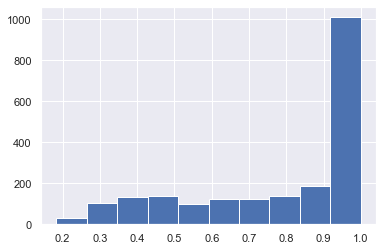

In [ ]:
pred_df['proba'] = max_probas
pred_df['proba'].hist()

При обработке данных на части фотографий не удалось распознать лица. Чтобы классифицировать такие фото я отдельно сформировала предсказания с помощью аналогичной модели на необрезанных фотографиях. И для тех объектов, где основная модель не очень уверена (опытным путем я определила порог в 0.4), я заменяю предсказания на результаты второй модели.  

In [ ]:
pred_no_haar = pd.read_csv('submission_no_haar.csv', header=0)
results = pd.concat([pred_df,pred_no_haar], axis = 1)

FileNotFoundError: ignored

In [ ]:
results['label'] = np.where(results['proba'] < 0.4, 
                                    results['pred_class_no_haar'], results['pred_class'])
pred_df = results.drop(['proba', 'img_name_no_haar', 'pred_class_no_haar'], axis=1)
pred_df.to_csv("submission_svm_best.csv", index=False)
pred_df.head()

,img_name,pred_class
0,image0.png,7
1,image1.png,3
2,image2.png,4
3,image3.png,5
4,image4.png,0


In [ ]:

pred_df.to_csv("first_submission.csv", index=False)